# Identify MHWs (marine heat waves) in an Australian Marine Park

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** modis_oc_1d development database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: module use /g/data/v10/public/modules/modulefiles;module load dea
    
* **Prerequisites:** The Introducion_to_MODIS_oceancolor notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats.Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instrucments can provide environmental information for Australian marine parks. However, they are often very expensive and lack spatial and/or temporal coverages.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we use [IMOS](http://imos.org.au/) MODIS SST (Sea Surface Temperature) data between 2002 and 2019 to identify the MHWs in the Cartier Island marine park. MHWs can have signficiant ecological and economic impacts. In this example, we use the definition of Hobday et al. (2016) to define a MHW event. A MHW is defined as a prolonged discrete anomalously warm water event that:
1. lasts for five or more days,
2. with SST warmer than the 90th percentile of baseline climatology, and
3. with well-defined start and end times.

Based on the SST anomaly between the maximum intensity and the 50th percentile (median) of baseline climatology, we have also classified a MHW event into one of four categories using the definition of Hobday et al. (2018):
1. Moderate: 1-2 times of the intensity threshold,
2. Strong: 2-3 times of the intensity threshold,
3. Severe: 3-4 times of the intensity threshold, and
4. Extreme: >4 times of the intensity threshold.

References:
1. Hobday, A.J., Alexander, L.V., Perkins, S.E., Smale, D.A., Straub, S.C., Oliver, E.C.J., Benthuysen, J., Burrows, M.T., Donat, M.G., Feng, M., Holbrook, N.J., Moore, P.J., Scannell, H.A., Gupta, A.S., & Wernberg, T. (2016). A hierarchical approach to defining marine heatwaves. Progress In Oceanography, 141, 227-238

2. Hobday, A.J., Oliver, E.C.J., Sen Gupta, A., Benthuysen, J., Burrows, M.T., Donat, M.G., Holbrook, N.J., Moore, P.J., Thomsen, M.S., Wernberg, T., & Smale, D.A. (2018). Categorizing and naming marine heatwaves. Oceanography, 31, 162-173


The worked example demonstrates how to:

1. Load in MODIS SST data
2. Create a buffer around the island/reefs to mask out the shallow water
3. Conduct zonal statistics to obtain an overall SST daily time series
4. Identify overall MHWs of the marine park
5. Identify per-pixel MHWs of the marine park 
6. Calculate summary MHWs statistics
7. Plot figures showing MHWs mapping results

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the \"Load packages\" cell.
    
**After finishing the analysis**, return to the \"Analysis parameters\" cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import fiona
import geopandas as gpd
import pandas as pd
import rasterio.features
import numpy as np
import shapefile as shpf
import scipy.ndimage as ndimage
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import matplotlib
import os
import time
import shapely


from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from matplotlib import gridspec
from shapely.geometry import shape, mapping
from rasterstats import zonal_stats
from affine import Affine
from datetime import datetime
from osgeo import ogr

In [2]:
now = time.time()

## Load MODIS SST data

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that modis_oc_1d is development product. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [3]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `output_crs`: The original MODIS SST data are in WGS84 coordinate system. If you want to change coordinate system please specify this prameter (e.g., 'EPSG:3577').
* `resoultion`: The desirable spatial resolution of the MODIS CHL data (e.g., '(-1300,1300)').
* `buffer_dist`: The distance (unit=metre) used to buffer the island/reefs to mask out the shallow water.
* `AMP_path`: The polygon shapefile of the Australian marine park
* `reef_path`: The polygon shapefile of the islands/reefs

In [4]:
output_crs = 'EPSG:4326'
resolution = (-0.01,0.01)
buffer_dist = 0.01
AMP_name = 'Ningaloo'
amp = 'NIN' # short name for the AMP
AMP_path = '/home/547/zxh547/dea-notebooks/shapefiles/CMR_2013_dissolved_wgs84.shp'
reef_path = '/home/547/zxh547/dea-notebooks/shapefiles/Territorial_Sea_offshore_reefs_polygons_inner_dissolved.shp'


### Buffer the island and erase the buffer from the marine park polygon

The erased polygon is used as the geometry to load the MODIS SST data

In [5]:
def geometry_to_shapefile(shapefileName,geom):
    
    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    # Write a new Shapefile
    with fiona.open(shapefileName, 'w', 'ESRI Shapefile', schema) as collection:
        ## If there are multiple geometries, put the "for" loop here
        collection.write({
            'geometry': mapping(geom),
            'properties': {'id': 1},
        })
    return

In [6]:
##open the polygon
driver = ogr.GetDriverByName("ESRI Shapefile")        
dataSource = driver.Open(AMP_path, 0)
layer = dataSource.GetLayer()
spatialRef = layer.GetSpatialRef()
crs = geometry.CRS(spatialRef.ExportToWkt())
print(crs)

for feature in layer:
    name = feature.GetField("MPA_NAME")
    if name == AMP_name:
        print(name)
        geom = shapely.wkt.loads(feature.GetGeometryRef().ExportToWkt())
        
        geom1 = geometry.Geometry(mapping(geom),crs=crs)

with fiona.open(reef_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom2 = geometry.Geometry(first_geometry, crs=crs)

a = shape(geom1) # the marine park polygon
#write the marine park polygon to a shapefile
AMP_shp = "marine_park.shp"
reefs_shp = "reefs.shp"
buffer_shp = "reefs_buffer.shp"

if os.path.exists(AMP_shp):
     driver.DeleteDataSource(AMP_shp)
if os.path.exists(reefs_shp):
    driver.DeleteDataSource(reefs_shp)
if os.path.exists(buffer_shp):
    driver.DeleteDataSource(buffer_shp)
    
geometry_to_shapefile(AMP_shp,a)

b =  geom2.intersection(geom1)
if b.is_empty: # reefs polygons do not intersect the marine park polyon
   newGeom1 = mapping(a)
else:
    c = shape(geom2.intersection(geom1)) # reefs within the marine park
    d = shape(c.buffer(buffer_dist)) # buffer the reefs with a distance of the buffer_dist parameter
    newGeom = a.difference(d) # erase the buffer from the marine park polygon
    newGeom1 = mapping(newGeom)      

    geometry_to_shapefile(reefs_shp,c)
    

    geometry_to_shapefile(buffer_shp,d)
    
newGeom2 = geometry.Geometry(newGeom1, crs=crs) # the newGeom2 geometry is used to load the MODIS data


GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
Ningaloo


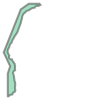

In [7]:
shape(newGeom2)

### Display the outlines of the island (red), the buffer (blue) and the marine park (black)

In [8]:
# CI = shpf.Reader(AMP_path)
# CI_I = shpf.Reader(reef_path)
# plt.figure(figsize=(9,9))
# # plot the marine park outline
# for shape1 in CI.shapeRecords():
#     x = [i[0] for i in shape1.shape.points[:]]
#     y = [i[1] for i in shape1.shape.points[:]]
#     plt.plot(x, y, 'k')
# # plot the island outline
# for shape1 in CI_I.shapeRecords():
#     x = [i[0] for i in shape1.shape.points[:]]
#     y = [i[1] for i in shape1.shape.points[:]]
#     plt.plot(x, y, 'k',color='red')
# # plot the buffer outline
# plt.plot(*b.exterior.xy,color='blue')

### Build query and load data

calculate the time taken to load the data

In [9]:
query = {'geopolygon': newGeom2,
         'output_crs': output_crs,
         'resolution': resolution
         }

In [10]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:17:38.721215 to finish


### Create a mask for the area covered by the erased marine park polygon
only keep data within the masked area

nodata is also masked

In [11]:
mask = rasterio.features.geometry_mask([newGeom2.to_crs(data.geobox.crs) for geoms in [newGeom2]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

**Mask the nodata (-999) as 'nan'**

In [12]:
data = mask_invalid_data(data)

### check the loaded MODIS SST data

note the time dimension

In [13]:
data

<xarray.Dataset>
Dimensions:    (latitude: 191, longitude: 76, time: 6214)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude   (latitude) float64 -21.66 -21.68 -21.68 ... -23.54 -23.55 -23.56
  * longitude  (longitude) float64 113.5 113.5 113.5 113.5 ... 114.2 114.2 114.2
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

### plot a daily SST image
A quick check of the loaded data

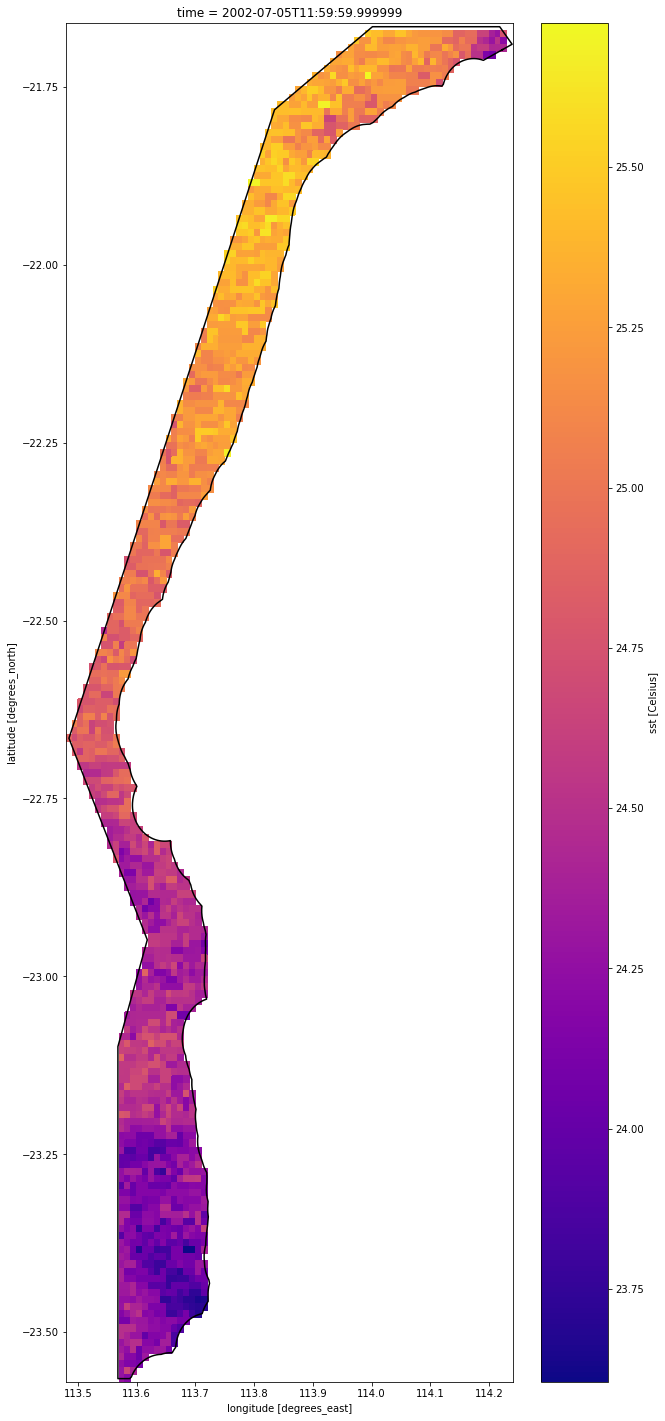

In [14]:
# determine the height and width of the figure using the spatial extent of the data
h_w_ratio = round(data.latitude.size / data.longitude.size, 1)
width = 10
height = round(width * h_w_ratio)

AMP = shpf.Reader(AMP_shp)
plt.figure(figsize=(width,height))
if os.path.exists(reefs_shp): 
    # plot the reefs/islands
    shape_plot = gpd.read_file(reefs_shp)
    shape_plot.plot(figsize=(width,height),color='gray')

# plot the marine park outline
for shape in AMP.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
# plot the SST image
data.sst[1].plot(cmap='plasma')

### the pad function (written by Eric Oliver) for linear interpolation of missing data in a time series

In [15]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


## conduct zonal statstists

conduct zonal statistics for all SST data

convert the results to a DataFrame

in doing so, we obtained the daily SST time-series of the marine park

In [16]:
# use the rasterstats module
time1 = datetime.now()
i = 0
propertiesList = []
dateList = []
while i < data['sst'].time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    sst = data.sst[i].data
    # note the list of the statistical parameters to be calculated
    stats = zonal_stats(AMP_shp,sst,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])
    i = i + 1
print('zonal stastistic done')
sstZonalDF = pd.DataFrame(propertiesList)
sstZonalDF['date']=dateList
sstZonalDF.set_index('date',inplace=True)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


zonal stastistic done
took 0:01:04.468068 to finish


**check that the dataframe of the time-series looks OK**

In [17]:
sstZonalDF

,id,min,max,mean,count,sum,std,median,range
date,,,,,,,,,
20020704,1,23.594999,25.450001,24.599671,2125,52274.300011,0.334282,24.610001,1.855001
20020705,1,23.605000,25.725000,24.771868,2125,52640.220015,0.477431,24.820000,2.120001
20020706,1,23.834999,26.455000,25.170024,2125,53486.299946,0.597966,25.315001,2.620001
20020707,1,22.035000,25.245001,24.501850,957,23448.270020,0.445573,24.615000,3.210001
20020708,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
20190718,1,23.299999,25.834999,24.701313,2125,52490.289953,0.514202,24.695000,2.535000
20190719,1,22.155001,24.934999,23.859462,2120,50582.060001,0.568833,24.010000,2.779999
20190720,1,22.290001,24.620001,23.699471,2125,50361.375029,0.522538,23.865000,2.330000


**plot the daily mean SST time-series for the marine park**

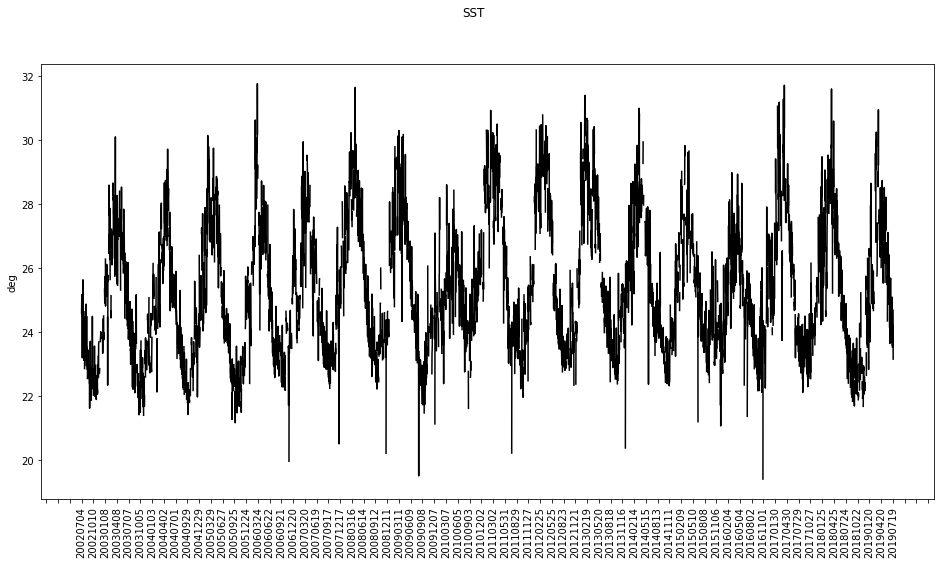

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(sstZonalDF.index.values,sstZonalDF['mean'].values,color='black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**apply interpolation on the daily mean, min and max SST time-series**

In [19]:
meanI = pad(sstZonalDF['mean'].values,maxPadLength=False)
minI = pad(sstZonalDF['min'].values,maxPadLength=False)
maxI = pad(sstZonalDF['max'].values,maxPadLength=False)

sstZonalDF['meanI'] = meanI
sstZonalDF['minI'] = minI
sstZonalDF['maxI'] = maxI

**plot the interploated daily SST mean, minimum and maximum time-series**

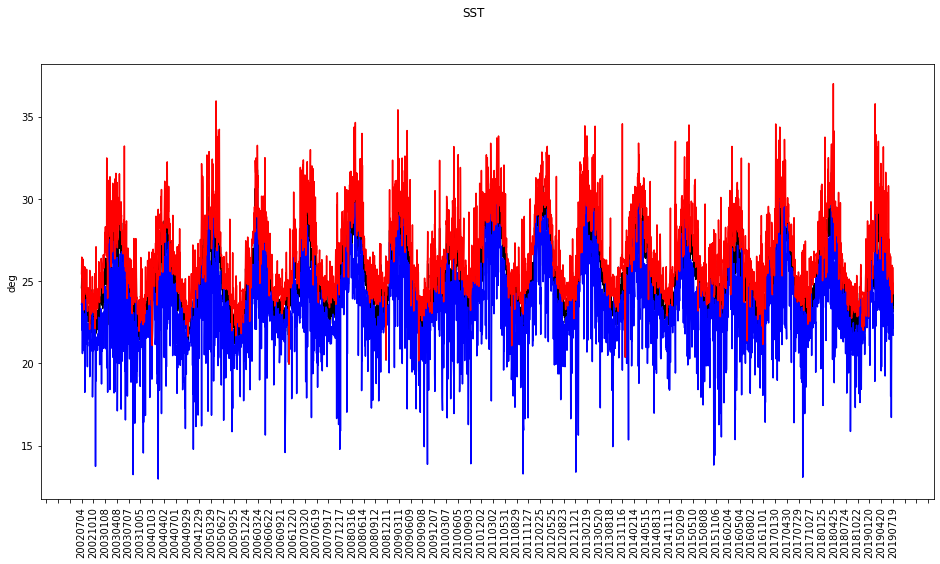

In [20]:

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(sstZonalDF.index.values,sstZonalDF['meanI'].values,color='black')
ax.plot(sstZonalDF.index.values,sstZonalDF['minI'].values,color='blue')
ax.plot(sstZonalDF.index.values,sstZonalDF['maxI'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

## Identify overall MHWs of the marine park

from the overall daily SST time-series

**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [21]:
sstZonalDF

,id,min,max,mean,count,sum,std,median,range,meanI,minI,maxI
date,,,,,,,,,,,,
20020704,1,23.594999,25.450001,24.599671,2125,52274.300011,0.334282,24.610001,1.855001,24.599671,23.594999,25.450001
20020705,1,23.605000,25.725000,24.771868,2125,52640.220015,0.477431,24.820000,2.120001,24.771868,23.605000,25.725000
20020706,1,23.834999,26.455000,25.170024,2125,53486.299946,0.597966,25.315001,2.620001,25.170024,23.834999,26.455000
20020707,1,22.035000,25.245001,24.501850,957,23448.270020,0.445573,24.615000,3.210001,24.501850,22.035000,25.245001
20020708,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,24.544228,22.682500,25.460000
...,...,...,...,...,...,...,...,...,...,...,...,...
20190718,1,23.299999,25.834999,24.701313,2125,52490.289953,0.514202,24.695000,2.535000,24.701313,23.299999,25.834999
20190719,1,22.155001,24.934999,23.859462,2120,50582.060001,0.568833,24.010000,2.779999,23.859462,22.155001,24.934999
20190720,1,22.290001,24.620001,23.699471,2125,50361.375029,0.522538,23.865000,2.330000,23.699471,22.290001,24.620001


In [22]:
sstZonalDF1 = sstZonalDF.drop(['20040229','20080229','20120229','20160229'])

**calculate dayofyear for each date**

In [23]:
i = 0
dayofyears = []

while i < sstZonalDF1.index.size:
    date = sstZonalDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    
    dayofyears.append(dayofyear)

    i = i + 1
sstZonalDF1['dayofyear']=dayofyears


### calculate the 90th percentile climatology data from the daily SST time-series

use 11-days window and smooth it with 31-days running average

In [24]:
time1 = datetime.now()

nintyZonalDF2 = pd.DataFrame()

nintyZonalList = []
dayofyearList = []
for date in sstZonalDF1.loc['20030101':'20031231'].index:
    dayofyear = sstZonalDF1.dayofyear.loc[date]
    if np.isin(dayofyear, dayofyearList):
        break
    else:
        dayofyearList.append(dayofyear)
    if dayofyear == 1:
        dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
    elif dayofyear == 2:
        dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
    elif dayofyear == 3:
        dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
    elif dayofyear == 4:
        dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
    elif dayofyear == 5:
        dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
    elif dayofyear == 365:
        dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
    elif dayofyear == 364:
        dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
    elif dayofyear == 363:
        dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
    elif dayofyear == 362:
        dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
    elif dayofyear == 361:
        dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
    else:
        dayofyears = np.arange(dayofyear-5,dayofyear+6,1)

    x = sstZonalDF1[sstZonalDF1.dayofyear.isin(dayofyears)]['meanI']
    x_90 = x.quantile(0.9)
    nintyZonalList.append(x_90)
nintyZonalDF2['meanI'] = nintyZonalList
nintyZonalDF2['dayofyear'] = dayofyearList
nintyZonalDF2.set_index('dayofyear', inplace=True)

nintyZonalDF3 = sstZonalDF1.copy(deep=True)

for date in nintyZonalDF3.index:
    dayofyear = nintyZonalDF3.dayofyear.loc[date]
    for doy in nintyZonalDF2.index:
        if dayofyear == doy:
            nintyZonalDF3.loc[date] = nintyZonalDF2.loc[doy]
            nintyZonalDF3.dayofyear.loc[date] = str(dayofyear)
    
##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

nintyZonalDF4 = nintyZonalDF3.copy(deep=True)

nintyZonalDF4 = nintyZonalDF4.rolling(31,center=True).mean()

nintyZonalDF4['dayofyear'] = nintyZonalDF3.dayofyear
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')



/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


took 0:00:44.212197 to finish


### calculate the mean climatology data from the daily SST time-series

use 11-days window and smooth it with 31-days running average

In [25]:
time1 = datetime.now()

meanZonalDF2 = pd.DataFrame()

meanZonalList = []
dayofyearList = []
for date in sstZonalDF1.loc['20030101':'20031231'].index:
    dayofyear = sstZonalDF1.dayofyear.loc[date]
    if np.isin(dayofyear, dayofyearList):
        break
    else:
        dayofyearList.append(dayofyear)
    if dayofyear == 1:
        dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
    elif dayofyear == 2:
        dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
    elif dayofyear == 3:
        dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
    elif dayofyear == 4:
        dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
    elif dayofyear == 5:
        dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
    elif dayofyear == 365:
        dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
    elif dayofyear == 364:
        dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
    elif dayofyear == 363:
        dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
    elif dayofyear == 362:
        dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
    elif dayofyear == 361:
        dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
    else:
        dayofyears = np.arange(dayofyear-5,dayofyear+6,1)

    x = sstZonalDF1[sstZonalDF1.dayofyear.isin(dayofyears)]['meanI']
    x_mean = x.mean()
    meanZonalList.append(x_mean)
meanZonalDF2['meanI'] = meanZonalList
meanZonalDF2['dayofyear'] = dayofyearList
meanZonalDF2.set_index('dayofyear', inplace=True)

meanZonalDF3 = sstZonalDF1.copy(deep=True)
for date in meanZonalDF3.index:
    dayofyear = meanZonalDF3.dayofyear.loc[date]
   
    for doy in meanZonalDF2.index:
        if dayofyear == doy:
            meanZonalDF3.loc[date] = meanZonalDF2.loc[doy]
            meanZonalDF3.dayofyear.loc[date] = str(dayofyear)
    

##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

meanZonalDF4 = meanZonalDF3.copy(deep=True)

meanZonalDF4 = meanZonalDF4.rolling(31,center=True).mean()

meanZonalDF4['dayofyear'] = meanZonalDF3.dayofyear

time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:00:43.466164 to finish


**plot the interpolated daily mean SST time-seires (blue), with the 90th percentile (red) and mean climatology (green)**

**The potential MHW days are those with daily mean SST values larger than the 90th prcentile**

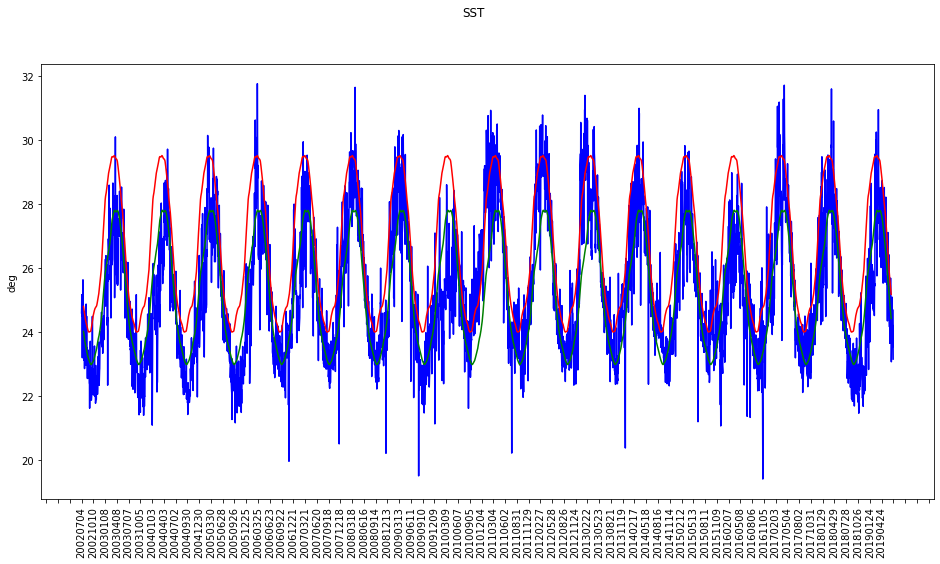

In [26]:

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.set_ylabel('deg')
fig.suptitle('SST')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(sstZonalDF1['meanI'],color='blue')
ax.plot(nintyZonalDF4['meanI'],color='red')

ax.plot(meanZonalDF4['meanI'],color='green')

### calculate the differences between the daily mean SST time-seires and the 90th percentile climatology

In [27]:
diffZonalDF4 = pd.DataFrame()
for i in sstZonalDF1.columns:
    if i == 'dayofyear':
        break
    else:
        diff = sstZonalDF1[i] - nintyZonalDF4[i]
        diffZonalDF4[i] = diff
   
diffZonalDF4['date'] = sstZonalDF1.index
diffZonalDF4.set_index('date', inplace=True)


### calculate the differences between the 90th percentile climatology and the mean climatology

In [28]:
thresholdZonalDF4 = pd.DataFrame()
for i in nintyZonalDF4.columns:
    if i == 'dayofyear':
        break
    else:
        diff = nintyZonalDF4[i] - meanZonalDF4[i]
        thresholdZonalDF4[i] = diff
   
thresholdZonalDF4['date'] = sstZonalDF1.index
thresholdZonalDF4.set_index('date', inplace=True)


### the main function to conduct the MHW analysis from the overall daily SST time-series of the marine park

In [29]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis_zonal(sstDiff_data,threshold_data,amp,outDir):
   
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    # the MHW classification, based on Hobday et al. (2018)
    totalMoList = [] # total moderate MHW days
    totalStList = [] # total strong MHW days
    totalSeList = [] # total severe MHW days
    totalExList = [] # total extreme MHW days
    
    # daily MHW intensity
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    
    # daily MHW classification
    statsClassDF = pd.DataFrame()
    statsClassDF['date'] = sstDiff_data.index
    statsClassDF.set_index('date',inplace=True)
        
    id = 'meanI'
    idList.append(id)
    # create a dataframe to store characteristics of the MHWs events identified for this point
    mhwE = pd.DataFrame()
    date_start = []
    date_end = []
    duration = []

    # get the point values as a numpy array, the empty value is NaN
    point1 = sstDiff_data[id]
    point1V = point1.values
    dates = sstDiff_data.index.values

    # get the threshold values as a numpy array, the empty value is NaN
    threshold1 = threshold_data[id]
    threshold1V = threshold1.values

    # replace the NaN values with '-9999'
    point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
    # convert negative values into 0 and positive values into 1
    point1V_1[point1V_1<=0] = False
    point1V_1[point1V_1>0] = True
    # label events: positive value(s)
    events, n_events = label(point1V_1)
 
    for ev in range(1,n_events+1):
        # calculate duration of an event
        event_duration = (events == ev).sum()
        # initially identify all events with duration of 4+ days
        # isolated 4-day event(s) will be eventually removed
        if event_duration > 3:
            date_start.append(dates[np.where(events == ev)[0][0]])
            date_end.append(dates[np.where(events == ev)[0][-1]])
            duration.append(event_duration)
    # the initial list of mhwE
    mhwE['date_start'] = date_start
    mhwE['date_end'] = date_end
    mhwE['duration'] = duration

    # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
    i = 0
    while i < mhwE.index.size - 1:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
        if gap < 3:
            # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
            if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                mhwE['date_end'][i] = mhwE['date_end'][i+1]
                mhwE = mhwE.drop(i+1)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1
        elif gap < 4:
            # condition 4: [>=5 hot, 2 cool, >=5 hot]
            if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                mhwE['date_end'][i] = mhwE['date_end'][i+1]
                mhwE = mhwE.drop(i+1)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1
        else:
            i = i + 1

    # drop the isolated event(s) with a duration of 4 days from the list
    i = 0
    while i < mhwE.index.size:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
        if duration == 4:
            mhwE = mhwE.drop(i)
            mhwE = mhwE.reset_index(drop=True)
            i = i
        else:
            i = i + 1

    # update the durations of the final list
    i = 0
    while i < mhwE.index.size:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
        mhwE['duration'][i] = duration
        i = i + 1

    # calculate mhw properties: intensity max, intensity mean, intensity std, 
    # cumulative intensity, onset rate and decline rate
    intensity_max = []
    intensity_mean = []
    intensity_std = []
    intensity_cumulative = []
    moderateD = []
    strongD = []
    severeD = []
    extremeD = []
    onset_rate = []
    decline_rate = []
    i = 0
    
    while i < mhwE.index.size:
        moderate = 0
        strong = 0
        severe = 0
        extreme = 0

        intensity_values = []
        date_values = []
        startDate = mhwE.iloc[i]['date_start']
        endDate = mhwE.iloc[i]['date_end']
        duration = mhwE.iloc[i]['duration']

        j = 0
        while j < sstDiff_data.index.size:

            date1 = dates[j]
            if startDate == date1:
                k = j + int(duration)

                while j < k:
                    sst_diff = point1V[j]
                    # calculate MHW classification
                    threshold = threshold1V[j]
                    ratio = sst_diff / threshold
                    if (ratio >= 0) & (ratio < 1.0):
                        moderate += 1
                    elif ratio < 2.0:
                        strong += 1
                    elif ratio < 3.0:
                        severe += 1
                    else:
                        extreme += 1

                    intensity_values.append(sst_diff)
                    dateV = dates[j]
                    date_values.append(dateV)
                    j = j + 1
            else:
                j = j + 1
      
        np_intensity = np.array(intensity_values)
        np_date = np.array(date_values)

        startDiff = np_intensity[0]
        endDiff = np_intensity[-1]
        maxDiff = np_intensity.max()
        meanDiff = np_intensity.mean()
        stdDiff = np_intensity.std()
        cumDiff = np_intensity.sum()

        peakDate = np_date[np_intensity == maxDiff][0]

        dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                    datetime.strptime(str(startDate),'%Y%m%d')).days
        if dateDiff1 > 0:        
            rateOnset = (maxDiff - startDiff) / dateDiff1
        else: # the start date is the peak date
            rateOnset = maxDiff / 0.5

        dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                    datetime.strptime(str(peakDate),'%Y%m%d')).days
        if dateDiff2 > 0:        
            rateDecline = (maxDiff - endDiff) / dateDiff2
        else: # the end date is the peak date
            rateDecline = maxDiff / 0.5
            
        intensity_max.append(maxDiff)
        intensity_mean.append(meanDiff)
        intensity_std.append(stdDiff)
        intensity_cumulative.append(cumDiff)

        onset_rate.append(rateOnset)
        decline_rate.append(rateDecline)

        moderateD.append(moderate)
        strongD.append(strong)
        severeD.append(severe)
        extremeD.append(extreme)

        i = i + 1

    mhwE['maxIntensity'] = intensity_max
    mhwE['meanIntensity'] = intensity_mean
    mhwE['stdIntensity'] = intensity_std
    mhwE['cumIntensity'] = intensity_cumulative

    mhwE['onsetRate'] = onset_rate
    mhwE['declineRate'] = decline_rate

    mhwE['moderate'] = moderateD
    mhwE['strong'] = strongD
    mhwE['severe'] = severeD
    mhwE['extreme'] = extremeD

    # save the MHWs events identified for the point into a CSV file
    filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
    mhwE.to_csv(filename, sep=',', index=False)

    # generate a statsDF to extract the intensity for the days identified as part of a MHW
    # generate a statsClassDF to extract the MHW classification for the days identified as part of a MHW
    if mhwE.index.size > 0:
        statsDF[str(id)] = np.nan
        statsClassDF[str(id)] = np.nan
        for j in mhwE.index:    
            date_start = str(int(mhwE.loc[j]['date_start']))
            date_end = str(int(mhwE.loc[j]['date_end']))
            x = sstDiff_data.loc[date_start:date_end][id].values
            y = threshold_data.loc[date_start:date_end][id].values
            # 2 -> moderate MHW; 3 -> strong MHW; 4 -> severe MHW; 5 -> extreme MHW
            z = np.array(x/y+2,dtype=int) # convert floating point to integer
            statsDF.loc[date_start:date_end,str(id)] = x
            statsClassDF.loc[date_start:date_end,str(id)] = z


#   geneate the summary characteristics of the MHWs    

    if mhwE.index.size > 0:

        noEvents.append(mhwE.index.size)
        noDays.append(mhwE['duration'].sum())
        totalIntensity.append(mhwE['cumIntensity'].sum())
        overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

        totalMoList.append(mhwE['moderate'].sum())
        totalStList.append(mhwE['strong'].sum())
        totalSeList.append(mhwE['severe'].sum())
        totalExList.append(mhwE['extreme'].sum())

        tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
        HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
        HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
        highestIntensity.append(mhwE['maxIntensity'].max())
        date_start_HI.append(HIDate)
        duration_HI.append(HIDuration)

        tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
        LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
        largestDuration.append(mhwE['duration'].max())
        date_start_LD.append(LDDate)
        intensityLD.append(intensityLDV)


        tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
        LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
        largestMeanIntensity.append(mhwE['meanIntensity'].max())
        date_start_LMI.append(LMIDate)
        duration_LMI.append(LMIDuration)    


        tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
        LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
        largestCumIntensity.append(mhwE['cumIntensity'].max())
        date_start_LCI.append(LCIDate)
        duration_LCI.append(LCIDuration)
    else:
        noEvents.append(0)
        noDays.append(0)
        totalIntensity.append(0)
        overallIntensity.append(0)

        totalMoList.append(0)
        totalStList.append(0)
        totalSeList.append(0)
        totalExList.append(0)

        highestIntensity.append(0)
        date_start_HI.append(0)
        duration_HI.append(0)


        largestDuration.append(0)
        date_start_LD.append(0)
        intensityLD.append(0)


        largestMeanIntensity.append(0)
        date_start_LMI.append(0)
        duration_LMI.append(0)

        largestCumIntensity.append(0)
        date_start_LCI.append(0)
        duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList

    
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
    mhwDF1['moderate'] = totalMoList
    mhwDF1['strong'] = totalStList
    mhwDF1['severe'] = totalSeList
    mhwDF1['extreme'] = totalExList
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    
    return mhwE, mhwDF1, statsDF, statsClassDF


### conduct MHW analysis for the Cartier Island AMP, using the overall daily mean SST time-series

In [30]:
time1 = datetime.now()
outdir = '/home/547/zxh547/dea-notebooks/' + amp + '_temp'
if os.path.isdir(outdir):
   print(outdir, 'exists') 
else:
    os.mkdir(outdir)

mhwZonal, mhwZonalDF4, statsZonalDF4, statsClassZonalDF4 = do_analysis_zonal(diffZonalDF4,thresholdZonalDF4,amp,outdir)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

/home/547/zxh547/dea-notebooks/NIN_temp exists


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


took 0:00:00.542294 to finish


### Check the MHW results from the overall daily mean SST time-series of the marine park

**the MHW results of individual events**

**note the properties of the individual events**

In [31]:
mhwZonal.tail(10)

,date_start,date_end,duration,maxIntensity,meanIntensity,stdIntensity,cumIntensity,onsetRate,declineRate,moderate,strong,severe,extreme
14,20130116,20130123,8,1.291402,0.718706,0.456101,5.749650,0.418629,0.322768,8,0,0,0
15,20130126,20130207,13,2.452788,1.116459,0.631548,14.513963,0.302486,0.397431,12,1,0,0
16,20130216,20130223,8,1.418099,1.157978,0.233885,9.263825,0.114199,0.043446,8,0,0,0
17,20130413,20130420,8,1.175472,0.505109,0.381951,4.040875,0.238900,0.228993,8,0,0,0
18,20140828,20140904,8,2.468262,0.578885,0.751012,4.631080,0.477914,1.080376,7,0,1,0
19,20150920,20150928,9,1.271780,0.629469,0.273747,5.665225,0.836779,0.089852,8,1,0,0
20,20150930,20151004,5,2.149741,1.036035,0.706528,5.180176,0.593266,1.799198,3,2,0,0
21,20151009,20151014,6,1.507514,0.677177,0.464864,4.063059,0.677191,0.451410,5,1,0,0
22,20161208,20161212,5,1.048509,0.586279,0.372886,2.931397,0.348454,0.120266,5,0,0,0
23,20170410,20170414,5,2.346334,0.964235,0.767575,4.821176,4.692668,0.578940,4,1,0,0


**the MHW results summarising all individual events**

In [32]:
mhwZonalDF4

,pointID,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,...,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI,moderate,strong,severe,extreme
0,meanI,24,205,166.273139,0.811088,2.912521,-737,14,26,-1473,...,1.234375,-737,14,24.204533,-1473,26,186,18,1,0


## Identify per-pixel MHWs of the marine park

from daily SST time-series of each pixel

### Convert per-pixel daily SST time-series into a dataframe

sstDF contains all SST data loaded: pixels (as columns) and date (as rows)

latlonDF contains the X and Y coordinates of the pixels

In [33]:
time1 = datetime.now()
sstDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.latitude.size:
    while lonIndex < data.longitude.size:
        lat = data.sst[:,latIndex,lonIndex].latitude.values
        lon = data.sst[:,latIndex,lonIndex].longitude.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        sstDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0

dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
sstDF['date'] = dateList
sstDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:01:33.272589 to finish


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [34]:
sstDF1 = sstDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame.** 

Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years

In [35]:
time1 = datetime.now()
i = 0
dayofyears = []

while i < sstDF1.index.size:
    date = sstDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
   
    dayofyears.append(dayofyear)

    i = i + 1
sstDF1['dayofyear']=dayofyears

time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:00:00.171233 to finish


**The sstIDF1 is generated from sstDF1 after applying the interpolation (pad) function**

In [36]:
time1 = datetime.now()
sstIDF1 = pd.DataFrame()
interpolatedSSTList = []

for i in sstDF1.columns:
    sst = sstDF1[i].values
    # drop the pixels with no observation data
    if np.isnan(sst).all():        
        latlonDF = latlonDF.drop(i, axis=0)
    else:
        interpolatedSST = pad(sst,maxPadLength=2)
        sstIDF1[i] = interpolatedSST
    
sstIDF1['date'] = sstDF1.index
sstIDF1['dayofyear'] = sstDF1['dayofyear'].values
sstIDF1.set_index('date', inplace=True)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:01:37.724277 to finish


### calculate the 90th percentile climatology data for the per-pixel time-series

use 11-days window and smooth it with 31-days running average

In [37]:
time1 = datetime.now()

nintyDF2 = pd.DataFrame()

for i in sstIDF1.columns:    
    nintyList = []
    dayofyearList = []
    for date in sstIDF1.loc['20030101':'20031231'].index:
        dayofyear = sstIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
       
        x = sstIDF1[sstIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF2[i] = nintyList
   

nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)

nintyDF3 = sstIDF1.copy(deep=True)

for date in nintyDF3.index:    
    dayofyear = nintyDF3.dayofyear.loc[date]
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    
##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

nintyDF4 = nintyDF3.copy(deep=True)

nintyDF4 = nintyDF4.rolling(31,center=True).mean()

nintyDF4['dayofyear'] = nintyDF3.dayofyear
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

It took  2:07:29.627716  to finish



### do similar thing to generate the mean climatology

In [38]:
time1 = datetime.now()

meanDF2 = pd.DataFrame()

for i in sstIDF1.columns:    
    meanList = []
    dayofyearList = []
    for date in sstIDF1.loc['20030101':'20031231'].index:
        dayofyear = sstIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        x = sstIDF1[sstIDF1.dayofyear.isin(dayofyears)][i]
        x_mean = x.mean()
        meanList.append(x_mean)
    meanDF2[i] = meanList
   
meanDF2['dayofyear'] = dayofyearList
meanDF2.set_index('dayofyear', inplace=True)

meanDF3 = sstIDF1.copy(deep=True)

for date in meanDF3.index:
    dayofyear = meanDF3.dayofyear.loc[date]
    for doy in meanDF2.index:
        if dayofyear == doy:
            meanDF3.loc[date] = meanDF2.loc[doy]
            meanDF3.dayofyear.loc[date] = str(dayofyear)
    
##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

meanDF4 = meanDF3.copy(deep=True)

meanDF4 = meanDF4.rolling(31,center=True).mean()

meanDF4['dayofyear'] = meanDF3.dayofyear
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

It took  1:52:44.801355  to finish


### Calculate the SST anomalies (differences) between the SST data and the 90th percentile climatology

use to identify MHWs

In [39]:
diffDF4 = pd.DataFrame()
for i in sstIDF1.columns:
    if i == 'dayofyear':
        break
    else:        
        diff = sstIDF1[i] - nintyDF4[i]
        diffDF4[i] = diff
   
diffDF4['date'] = sstDF1.index
diffDF4.set_index('date', inplace=True)


### calculate the SST anomaly thresholds between the 90th percentile and the mean climatology

use to classify MHW categories

In [40]:
thresholdDF4 = pd.DataFrame()
for i in nintyDF4.columns:
    if i == 'dayofyear':
        break
    else:
        
        diff = nintyDF4[i] - meanDF4[i]
        thresholdDF4[i] = diff
   
thresholdDF4['date'] = sstDF1.index
thresholdDF4.set_index('date', inplace=True)


**plot the 90th percentile (red) and the mean climatology (green), and the SST time-series (after interpolation) (black)**

just to check

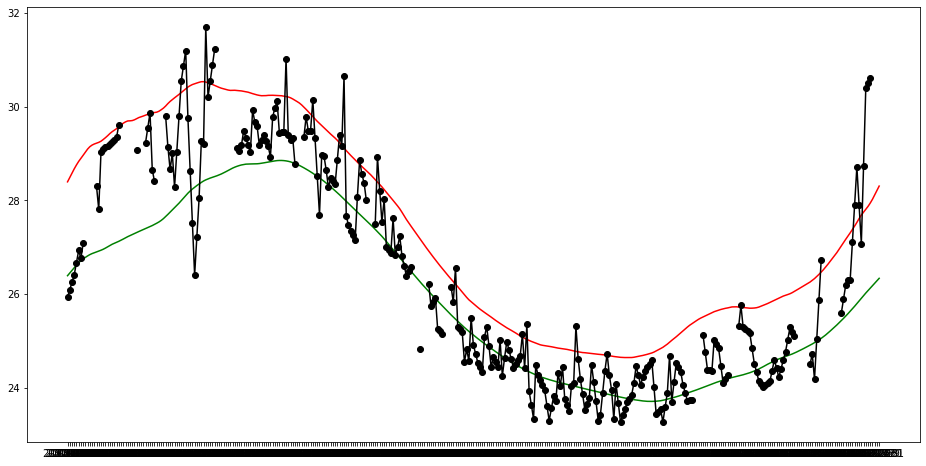

In [41]:
fig = plt.figure(figsize=(16,8))
col = sstIDF1.columns[1] # pick one column as an example
plt.plot(nintyDF4.loc['20120101':'20121231'][col],color='red')
plt.plot(meanDF4.loc['20120101':'20121231'][col],color='green')
plt.plot(sstIDF1.loc['20120101':'20121231'][col],color='black',marker='o')

### The main function to identify the MHW events and generate statistics. 

Return three dataframes. 

One contains the summary statistics. Another contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The third contains the daily MHW classification. The function also saves individual MHW files and the summary statistics file.

In [42]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd

def do_analysis(sstDiff_data,threshold_data,lonlatDF,amp,outDir):   
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    # the MHW classification, based on Hobday et al. (2018)
    totalMoList = [] # total moderate MHW days
    totalStList = [] # total strong MHW days
    totalSeList = [] # total severe MHW days
    totalExList = [] # total extreme MHW days
    
    # daily MHW intensity
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    
    # daily MHW classification
    statsClassDF = pd.DataFrame()
    statsClassDF['date'] = sstDiff_data.index
    statsClassDF.set_index('date',inplace=True)
    
    # loop through each pixel (point)
    for id in sstDiff_data.columns:
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values
        
        # get the threshold values as a numpy array, the empty value is NaN
        threshold1 = threshold_data[id]
        threshold1V = threshold1.values
        

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        
        # label events: positive value(s)       
        events, n_events = label(point1V_1)
   
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:
                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []
        moderateD = []
        strongD = []
        severeD = []
        extremeD = []

        onset_rate = []
        decline_rate = []
        i = 0        
        
        while i < mhwE.index.size:
            moderate = 0
            strong = 0
            severe = 0
            extreme = 0
            
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:
                        sst_diff = point1V[j]
                        # calculate MHW classification
                        threshold = threshold1V[j]
                        ratio = sst_diff / threshold
                        if (ratio >= 0) & (ratio < 1.0):
                            moderate += 1
                        elif ratio < 2.0:
                            strong += 1
                        elif ratio < 3.0:
                            severe += 1
                        else:
                            extreme += 1
                            
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
    
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5
                
            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            
            moderateD.append(moderate)
            strongD.append(strong)
            severeD.append(severe)
            extremeD.append(extreme)
            
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate
        
        mhwE['moderate'] = moderateD
        mhwE['strong'] = strongD
        mhwE['severe'] = severeD
        mhwE['extreme'] = extremeD

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        # generate a statsClassDF to extract the MHW classification for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            statsClassDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                x = sstDiff_data.loc[date_start:date_end][id].values
                y = thresholdDF4.loc[date_start:date_end][id].values
                # 2 -> moderate; 3 -> strong; 4 -> severe; 5 -> extreme
                z = np.array(x/y+2,dtype=int) # convert floating point to integer
                statsDF.loc[date_start:date_end,str(id)] = x
                statsClassDF.loc[date_start:date_end,str(id)] = z                
         

    #   geneate the summary characteristics of the MHWs    
   
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())
            
            totalMoList.append(mhwE['moderate'].sum())
            totalStList.append(mhwE['strong'].sum())
            totalSeList.append(mhwE['severe'].sum())
            totalExList.append(mhwE['extreme'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)
            
            totalMoList.append(0)
            totalStList.append(0)
            totalSeList.append(0)
            totalExList.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
    mhwDF1['moderate'] = totalMoList
    mhwDF1['strong'] = totalStList
    mhwDF1['severe'] = totalSeList
    mhwDF1['extreme'] = totalExList
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
  
    return mhwDF1, statsDF, statsClassDF


### Apply the main function to identify per-pixel MHWs of the marine park

mhwDF4 contains the per-pixel MHWs' summarised results. statsDF4 contains the per-pixel intensities of the MHW days, so that we can generate daily spatial statistics. statsClassDF4 contains the daily MHW classification.

In [43]:
time1 = datetime.now()

outdir = '/home/547/zxh547/dea-notebooks/' + amp
if os.path.isdir(outdir):
   print(outdir, 'exists') 
else:
    os.mkdir(outdir)

mhwDF4, statsDF4, statsClassDF4 = do_analysis(diffDF4,thresholdDF4,latlonDF,amp,outdir)
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

/home/547/zxh547/dea-notebooks/NIN exists


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


It took  0:14:38.297017  to finish


**check the per-pixel MHWs' summarised results** 

In [44]:
mhwDF4.tail(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,...,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI,moderate,strong,severe,extreme
2115,14226,-23.535,113.615,22,168,123.098912,0.732732,3.674532,-1468,5,...,2.378846,-1468,5,22.862420,-1539,28,149,18,1,0
2116,14298,-23.544999999999998,113.575,19,158,113.423288,0.717869,3.611997,-1452,5,...,2.355639,-1468,5,23.788280,-1539,28,139,17,2,0
2117,14299,-23.544999999999998,113.585,17,148,108.211139,0.731156,3.490395,-1452,5,...,2.207692,-1468,5,24.843146,-1540,29,135,12,1,0
2118,14300,-23.544999999999998,113.595,21,163,115.631570,0.709396,3.303527,-1468,5,...,2.310439,-1468,5,14.218839,-1525,14,145,17,1,0
2119,14301,-23.544999999999998,113.605,18,155,99.997203,0.645143,3.291054,-1452,5,...,2.090126,-1452,5,13.345094,-1525,14,138,17,0,0
2120,14374,-23.555,113.575,20,165,119.987239,0.727195,3.299269,-1452,5,...,2.440179,-1468,5,12.242887,-1525,14,145,19,1,0
2121,14375,-23.555,113.585,21,166,113.684229,0.684845,3.359239,-1452,5,...,2.301109,-1468,5,12.983146,-1525,14,151,14,1,0
2122,14376,-23.555,113.595,20,170,107.379428,0.631644,3.251866,-1452,5,...,1.912585,-1452,5,24.000742,-1542,31,155,15,0,0
2123,14450,-23.564999999999998,113.575,16,130,96.813407,0.744719,3.402315,-1468,5,...,2.527492,-1468,5,21.212095,-1541,30,116,13,1,0
2124,14451,-23.564999999999998,113.585,19,156,108.091963,0.692897,3.210438,-1468,5,...,2.410723,-1468,5,23.979065,-1542,31,137,18,1,0


## calculate summary MHWs statistics

daily and seasonal

### Generate summarised daily MHW statistics

**Calculate summary statistics (e.g., min, max, mean, etc) for the statsDF dataframe**

In [45]:
time1 = datetime.now()
minList = []
maxList = []
meanList = []
stdList = []
countList = []
observedList = []
#loop through each date
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
    x = sstIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(x)) - 1
    observedList.append(observed)
statsDF4['min'] = minList # minimum MHW intensity over the entire marine park
statsDF4['max'] = maxList # maximum MHW intensity over the entire marine park
statsDF4['mean'] = meanList # mean of the MHW intensties over the entire marine park
statsDF4['std'] = stdList # standard deviation of the MHW intensities over the entire marine park
statsDF4['count'] = countList # number of MHW pixels identified over the entire marine park
statsDF4['observed'] = observedList # number of pixels observed by MODIS over the entire marine park
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')
    

It took  0:00:21.633689  to finish


**calculate the summary statistics for the statsClassDF**

In [46]:
time1 = datetime.now()
moCountList = []
stCountList = []
seCountList = []
exCountList = []
countList = []
observedList = []
# the number of pixels of individual MHW classes
for i in statsClassDF4.index:
    x = statsClassDF4.loc[i]
    moCount = x[x==2].size
    stCount = x[x==3].size
    seCount = x[x==4].size
    exCount = x[x==5].size
    moCountList.append(moCount)
    stCountList.append(stCount)
    seCountList.append(seCount)
    exCountList.append(exCount)
    countList.append(x.count())
    y = sstIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(y)) - 1
    observedList.append(observed)
statsClassDF4['moCount'] = moCountList # number of moderate MHW pixels over the entire marine park
statsClassDF4['stCount'] = stCountList # number of strong MHW pixels over the entire marine park
statsClassDF4['seCount'] = seCountList # number of severe MHW pixels over the entire marine park
statsClassDF4['exCount'] = exCountList # number of extreme MHW pixels over the entire marine park
statsClassDF4['count'] = countList # number of MHW pixels identified over the entire marine park
statsClassDF4['observed'] = observedList # number of pixels observed by MODIS over the entire marine park
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')
    

It took  0:00:31.005302  to finish


### Generate seasonal statistics from daily MHW statistics

**Generate seasonal statistics from statsDF4**

In [47]:
time1 = datetime.now()
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = [] # the total number of MHW pixels within the season
observed1List = [] # the total number of pixels observed by MODIS on those MHW days within the season
observed2List = [] # the totoal number of pixels observed by MODIS within the season
mhwDaysList = [] # total number of mhwDays within the season
nodataDaysList = [] # the total number of nodata days (ie. no MODIS data for the days) within the season
noDaysList = [] # total number of days within the season
mhwPixelsList = [] # number of pixels in the marine park affected by MHW on at least one day of the season
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20020704':'20020831',col1:col2].values

if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size) 
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20020704':'20020831','observed'].values
observed2 = y.sum() 
observed2List.append(observed2)
nodataDays = (y==0).sum() 
nodataDaysList.append(nodataDays)
z=statsDF4.loc['20020704':'20020831','count'].values
k = y[z>0]
observed1List.append(k.sum())  
mhwDaysList.append(k.size) 
noDaysList.append(z.size) 
# calculate number of pixels in the marine park affected by MHW on at least one day of the season
x=statsDF4.loc['20020704':'20020831',col1:col2]
j = 0
for col in x.columns:
    a = x[col]
    if a.count() > 0:
        j += 1
mhwPixelsList.append(j)


yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    nodataDays = (y==0).sum()
    nodataDaysList.append(nodataDays)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    x=statsDF4.loc[date1:date2,col1:col2]
    j = 0
    for col in x.columns:
        a = x[col]
        if a.count() > 0:
            j += 1
    mhwPixelsList.append(j)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    nodataDays = (y==0).sum()
    nodataDaysList.append(nodataDays)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    x=statsDF4.loc[date1:date2,col1:col2]
    j = 0
    for col in x.columns:
        a = x[col]
        if a.count() > 0:
            j += 1
    mhwPixelsList.append(j)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    nodataDays = (y==0).sum()
    nodataDaysList.append(nodataDays)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    x=statsDF4.loc[date1:date2,col1:col2]
    j = 0
    for col in x.columns:
        a = x[col]
        if a.count() > 0:
            j += 1
    mhwPixelsList.append(j)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    nodataDays = (y==0).sum()
    nodataDaysList.append(nodataDays)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    x=statsDF4.loc[date1:date2,col1:col2]
    j = 0
    for col in x.columns:
        a = x[col]
        if a.count() > 0:
            j += 1
    mhwPixelsList.append(j)   
    
    i += 1

x=statsDF4.loc['20180901':'20181130',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20180901':'20181130','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
nodataDays = (y==0).sum()
nodataDaysList.append(nodataDays)
z=statsDF4.loc['20180901':'20181130','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
x=statsDF4.loc['20180901':'20181130',col1:col2]
j = 0
for col in x.columns:
    a = x[col]
    if a.count() > 0:
        j += 1
mhwPixelsList.append(j)
    
x=statsDF4.loc['20181201':'20190228',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20181201':'20190228','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
nodataDays = (y==0).sum()
nodataDaysList.append(nodataDays)
z=statsDF4.loc['20181201':'20190228','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
x=statsDF4.loc['20181201':'20190228',col1:col2]
j = 0
for col in x.columns:
    a = x[col]
    if a.count() > 0:
        j += 1
mhwPixelsList.append(j)

x=statsDF4.loc['20190301':'20190531',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190301':'20190531','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
nodataDays = (y==0).sum()
nodataDaysList.append(nodataDays)
z=statsDF4.loc['20190301':'20190531','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
x=statsDF4.loc['20190301':'20190531',col1:col2]
j = 0
for col in x.columns:
    a = x[col]
    if a.count() > 0:
        j += 1
mhwPixelsList.append(j)

x=statsDF4.loc['20190601':'20190722',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190601':'20190722','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
nodataDays = (y==0).sum()
nodataDaysList.append(nodataDays)
z=statsDF4.loc['20190601':'20190722','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
x=statsDF4.loc['20190601':'20190722',col1:col2]
j = 0
for col in x.columns:
    a = x[col]
    if a.count() > 0:
        j += 1
mhwPixelsList.append(j)

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList
seasonDF4['observed1'] = observed1List
seasonDF4['observed2'] = observed2List
seasonDF4['mhwDays'] = mhwDaysList
seasonDF4['nodataDays'] = nodataDaysList
seasonDF4['noDays'] = noDaysList
seasonDF4['mhwPixels'] = mhwPixelsList
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

128 14451


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal


20020901 20021130


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater_equal


20021201 20030228


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater_equal


20030301 20030531


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in greater_equal


20030601 20030831


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/pyth

20030901 20031130


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in greater_equal


20031201 20040228
20040301 20040531


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in greater_equal


20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in greater_equal


20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 20160831
20160901 20161130
20161201 20170228
20170301 20170531
20170601 20170831
20170901 20171130
20171201 20180228
20180301 20180531
20180601 20180831


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:294: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:295: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:296: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:297: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20191127/lib/pyth

It took  0:00:25.716581  to finish


**generate seasonal statistics from statsClassDF**

In [48]:
time1 = datetime.now()
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonClassDF4 = pd.DataFrame()
seasonClassDF4['season'] = seasonList
seasonClassDF4.set_index('season',inplace=True)
moCountList = [] # total number of pixels identified as moderate MHW, within the season
stCountList = [] # total number of pixels identified as strong MHW, within the season
seCountList = [] # total number of pixels identified as severe MHW, within the season
exCountList = [] # total number of pixels identified as extreme MHW, within the season
moDaysList = [] # total number of moderate MHW days, within the season
stDaysList = [] # total number of strong MHW days, within the season
seDaysList = [] # total number of severe MHW days, within the season
exDaysList = [] # total number of extreme MHW days, within the season
moPixelsList = [] # number of marine park pixels affected by moderate MHW at least one day of the season
stPixelsList = [] # number of marine park pixels affected by strong MHW at least one day of the season
sePixelsList = [] # number of marine park pixels affected by severe MHW at least one day of the season
exPixelsList = [] # number of marine park pixels affected by extreme MHW at least one day of the season
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)

mo=statsClassDF4.loc['20020704':'20020831','moCount'].values
st=statsClassDF4.loc['20020704':'20020831','stCount'].values
se=statsClassDF4.loc['20020704':'20020831','seCount'].values
ex=statsClassDF4.loc['20020704':'20020831','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20020704':'20020831','moCount':'exCount'].values
i = 0
exDays = 0 
seDays = 0 
stDays = 0 
moDays = 0 
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

moPixel = 0
stPixel = 0 
sePixel = 0 
exPixel = 0 
x=statsClassDF4.loc['20020704':'20020831',col1:col2]
for col in x.columns:
    a = x[col]
    if a.max() == 2:
        moPixel += 1
    elif a.max() == 3:
        stPixel += 1
    elif a.max() == 4:
        sePixel += 1
    elif a.max() == 5:
        exPixel += 1
        
moPixelsList.append(moPixel)
stPixelsList.append(stPixel)
sePixelsList.append(sePixel)
exPixelsList.append(exPixel)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
j = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)    
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    moPixel = 0
    stPixel = 0
    sePixel = 0
    exPixel = 0
    x=statsClassDF4.loc[date1:date2,col1:col2]
    for col in x.columns:
        a = x[col]
        if a.max() == 2:
            moPixel += 1
        elif a.max() == 3:
            stPixel += 1
        elif a.max() == 4:
            sePixel += 1
        elif a.max() == 5:
            exPixel += 1

    moPixelsList.append(moPixel)
    stPixelsList.append(stPixel)
    sePixelsList.append(sePixel)
    exPixelsList.append(exPixel)

    date1 = year+'1201'
    date2 = yearList[j+1] + '0228'
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    moPixel = 0
    stPixel = 0
    sePixel = 0
    exPixel = 0
    x=statsClassDF4.loc[date1:date2,col1:col2]
    for col in x.columns:
        a = x[col]
        if a.max() == 2:
            moPixel += 1
        elif a.max() == 3:
            stPixel += 1
        elif a.max() == 4:
            sePixel += 1
        elif a.max() == 5:
            exPixel += 1

    moPixelsList.append(moPixel)
    stPixelsList.append(stPixel)
    sePixelsList.append(sePixel)
    exPixelsList.append(exPixel)
    
    date1 = yearList[j+1] + '0301'
    date2 = yearList[j+1] + '0531'
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    moPixel = 0
    stPixel = 0
    sePixel = 0
    exPixel = 0
    x=statsClassDF4.loc[date1:date2,col1:col2]
    for col in x.columns:
        a = x[col]
        if a.max() == 2:
            moPixel += 1
        elif a.max() == 3:
            stPixel += 1
        elif a.max() == 4:
            sePixel += 1
        elif a.max() == 5:
            exPixel += 1

    moPixelsList.append(moPixel)
    stPixelsList.append(stPixel)
    sePixelsList.append(sePixel)
    exPixelsList.append(exPixel)
    date1 = yearList[j+1] + '0601'
    date2 = yearList[j+1] + '0831' 
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    moPixel = 0
    stPixel = 0
    sePixel = 0
    exPixel = 0
    x=statsClassDF4.loc[date1:date2,col1:col2]
    for col in x.columns:
        a = x[col]
        if a.max() == 2:
            moPixel += 1
        elif a.max() == 3:
            stPixel += 1
        elif a.max() == 4:
            sePixel += 1
        elif a.max() == 5:
            exPixel += 1

    moPixelsList.append(moPixel)
    stPixelsList.append(stPixel)
    sePixelsList.append(sePixel)
    exPixelsList.append(exPixel)
    j += 1

mo=statsClassDF4.loc['20180901':'20181130','moCount'].values
st=statsClassDF4.loc['20180901':'20181130','stCount'].values
se=statsClassDF4.loc['20180901':'20181130','seCount'].values
ex=statsClassDF4.loc['20180901':'20181130','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20180901':'20181130','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

moPixel = 0
stPixel = 0
sePixel = 0
exPixel = 0
x=statsClassDF4.loc['20180901':'20181130',col1:col2]
for col in x.columns:
    a = x[col]
    if a.max() == 2:
        moPixel += 1
    elif a.max() == 3:
        stPixel += 1
    elif a.max() == 4:
        sePixel += 1
    elif a.max() == 5:
        exPixel += 1

moPixelsList.append(moPixel)
stPixelsList.append(stPixel)
sePixelsList.append(sePixel)
exPixelsList.append(exPixel)

mo=statsClassDF4.loc['20181201':'20190228','moCount'].values
st=statsClassDF4.loc['20181201':'20190228','stCount'].values
se=statsClassDF4.loc['20181201':'20190228','seCount'].values
ex=statsClassDF4.loc['20181201':'20190228','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20181201':'20190228','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

moPixel = 0
stPixel = 0
sePixel = 0
exPixel = 0
x=statsClassDF4.loc['20181201':'20190228',col1:col2]
for col in x.columns:
    a = x[col]
    if a.max() == 2:
        moPixel += 1
    elif a.max() == 3:
        stPixel += 1
    elif a.max() == 4:
        sePixel += 1
    elif a.max() == 5:
        exPixel += 1

moPixelsList.append(moPixel)
stPixelsList.append(stPixel)
sePixelsList.append(sePixel)
exPixelsList.append(exPixel)


mo=statsClassDF4.loc['20190301':'20190531','moCount'].values
st=statsClassDF4.loc['20190301':'20190531','stCount'].values
se=statsClassDF4.loc['20190301':'20190531','seCount'].values
ex=statsClassDF4.loc['20190301':'20190531','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20190301':'20190531','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

moPixel = 0
stPixel = 0
sePixel = 0
exPixel = 0
x=statsClassDF4.loc['20190301':'20190531',col1:col2]
for col in x.columns:
    a = x[col]
    if a.max() == 2:
        moPixel += 1
    elif a.max() == 3:
        stPixel += 1
    elif a.max() == 4:
        sePixel += 1
    elif a.max() == 5:
        exPixel += 1

moPixelsList.append(moPixel)
stPixelsList.append(stPixel)
sePixelsList.append(sePixel)
exPixelsList.append(exPixel)

mo=statsClassDF4.loc['20190601':'20190722','moCount'].values
st=statsClassDF4.loc['20190601':'20190722','stCount'].values
se=statsClassDF4.loc['20190601':'20190722','seCount'].values
ex=statsClassDF4.loc['20190601':'20190722','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20190601':'20190722','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

moPixel = 0
stPixel = 0
sePixel = 0
exPixel = 0
x=statsClassDF4.loc['20190601':'20190722',col1:col2]
for col in x.columns:
    a = x[col]
    if a.max() == 2:
        moPixel += 1
    elif a.max() == 3:
        stPixel += 1
    elif a.max() == 4:
        sePixel += 1
    elif a.max() == 5:
        exPixel += 1

moPixelsList.append(moPixel)
stPixelsList.append(stPixel)
sePixelsList.append(sePixel)
exPixelsList.append(exPixel)

seasonClassDF4['moCount'] = moCountList
seasonClassDF4['stCount'] = stCountList
seasonClassDF4['seCount'] = seCountList
seasonClassDF4['exCount'] = exCountList
seasonClassDF4['moDays'] = moDaysList
seasonClassDF4['stDays'] = stDaysList
seasonClassDF4['seDays'] = seDaysList
seasonClassDF4['exDays'] = exDaysList
seasonClassDF4['count'] = seasonDF4['count']
seasonClassDF4['observed1'] = seasonDF4['observed1']
seasonClassDF4['observed2'] = seasonDF4['observed2']
seasonClassDF4['mhwDays'] = seasonDF4['mhwDays']
seasonClassDF4['nodataDays'] = seasonDF4['nodataDays']
seasonClassDF4['noDays'] = seasonDF4['noDays']
seasonClassDF4['moPixels'] = moPixelsList
seasonClassDF4['stPixels'] = stPixelsList
seasonClassDF4['sePixels'] = sePixelsList
seasonClassDF4['exPixels'] = exPixelsList
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

128 14451
20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531


## Plot figures showing MHWs mapping results

**Plot a figure using the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW, non-MHW and nodata for each season. The colors indicates other statistics, for example the mean MHW intensity 
in this case.**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


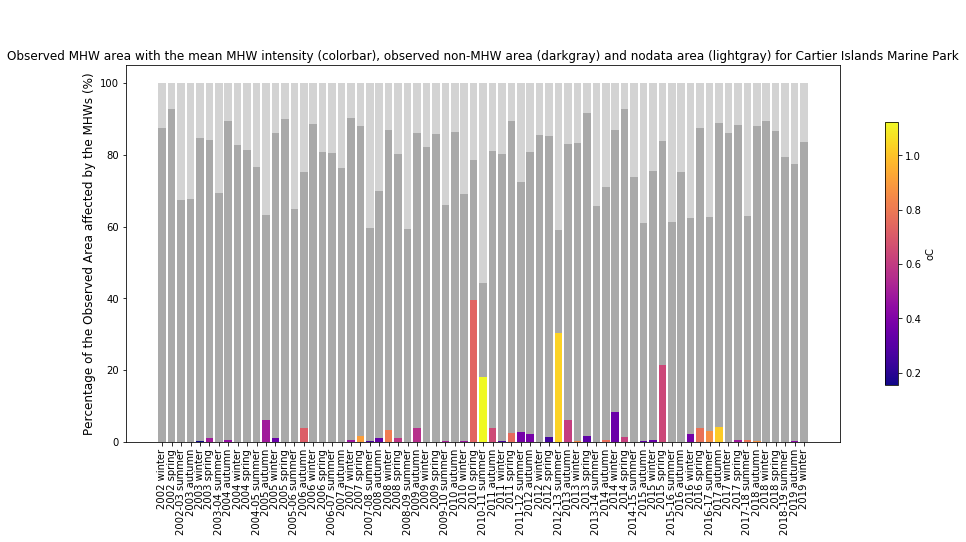

In [49]:

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
mhwPixels = seasonDF4['count'].values
observedPixels = seasonDF4['observed2'].values
totalPixels = (sstIDF1.columns.size - 1) * seasonDF4['noDays'].values
nonMHWPixels = observedPixels - mhwPixels
nodataPixels = totalPixels - observedPixels
y1 = mhwPixels / totalPixels * 100
y2 = nonMHWPixels / totalPixels * 100
y3 = nodataPixels / totalPixels * 100
z1 = seasonDF4['mean'].values # display as colormap according to its values
mhwDays = seasonDF4['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y1[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], y2[i], bottom=y1[i], facecolor="darkgray", alpha=1)
    ax1.bar(x[i], y3[i], bottom=y1[i]+y2[i], facecolor="lightgray", alpha=1)
    
    i += 1

ax1.set_ylabel("Percentage of the Observed Area affected by the MHWs (%)",fontsize=12)
ax1.set_title('Observed MHW area with the mean MHW intensity (colorbar), observed non-MHW area (darkgray) and nodata area (lightgray) for ' + AMP_name + ' Marine Park')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**Plot a figure using the seasonal statistics. The height of the y-axis shows the number of days that have been 
identified as MHW, non-MHW and nodata for each season. The colors indicates other statistics, for example the mean MHW intensity in this case.**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


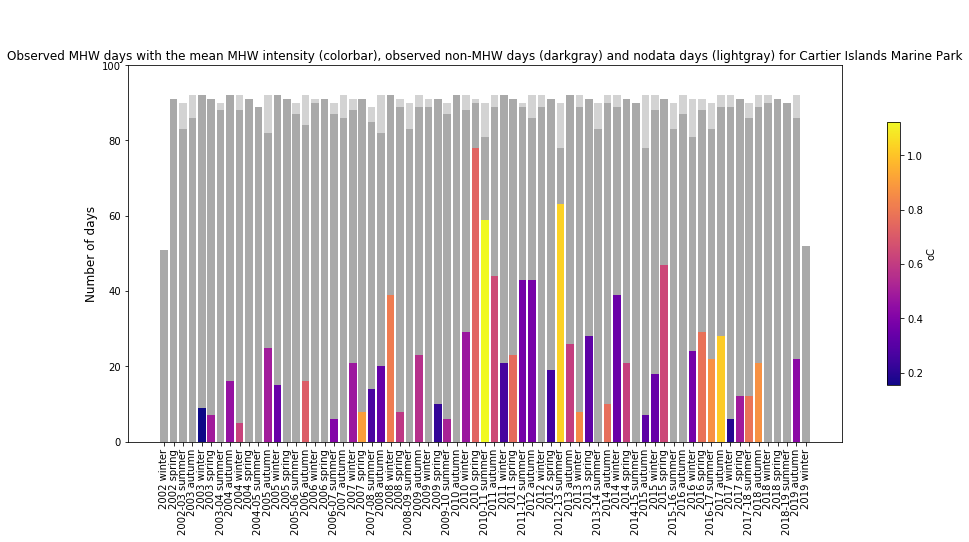

In [50]:

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
mhwDays = seasonDF4['mhwDays'].values
nodataDays = seasonDF4['nodataDays'].values
totalDays = seasonDF4['noDays'].values
nonMHWDays = totalDays - nodataDays - mhwDays

z1 = seasonDF4['mean'].values # display as colormap according to its values
mhwDays = seasonDF4['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], mhwDays[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], nonMHWDays[i], bottom=mhwDays[i], facecolor="darkgray", alpha=1)
    ax1.bar(x[i], nodataDays[i], bottom=mhwDays[i]+nonMHWDays[i], facecolor="lightgray", alpha=1)
    
    i += 1


ax1.set_ylabel("Number of days",fontsize=12)
ax1.set_title('Observed MHW days with the mean MHW intensity (colorbar), observed non-MHW days (darkgray) and nodata days (lightgray) for ' + AMP_name + ' Marine Park')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylim(0,100)    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**Plot a figure using the seasonal statistics. The left y-axis shows the percentage of marine park that have been 
affected by MHWs at some points of time within the season. The right y-axis shows the number of MHW days. The colors indicates other statistics, for example the mean MHW intensity in this case.**

[-10.   0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


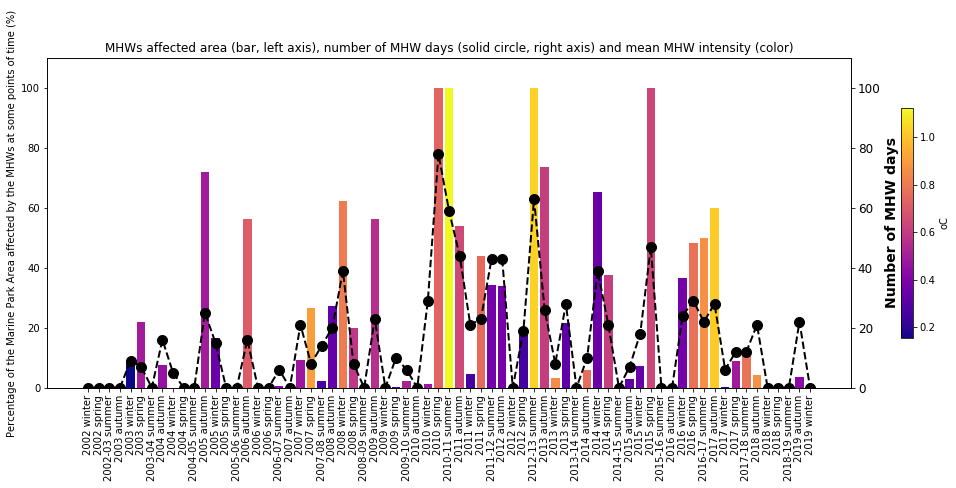

In [51]:

fig = plt.figure(figsize=(18,7))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
totalPixels = sstIDF1.columns.size - 1
y = seasonDF4['mhwPixels'].values / totalPixels * 100
z1 = seasonDF4['mean'].values # display as colormap according to its values
mhwDays = seasonDF4['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax2 = ax1.twinx()
ax2.plot(x, mhwDays, color='black', linestyle='dashed', marker='o', linewidth=2, markersize=10)
ax2.set_ylabel('Number of MHW days', fontsize=14, fontweight='bold')
ax2.tick_params(colors='black',labelsize=12)
loc = ax2.get_yticks()
print(loc)
ax2.set_ylim(0,110)

ax1.set_ylabel("Percentage of the Marine Park Area affected by the MHWs at some points of time (%)",fontsize=10)
ax1.set_title('MHWs affected area (bar, left axis), number of MHW days (solid circle, right axis) and mean MHW intensity (color)')
ax1.set_ylim(0,110)
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**plot a figure showing the percentages of the marine park area affected by different MHW categories at some points of time within the season**

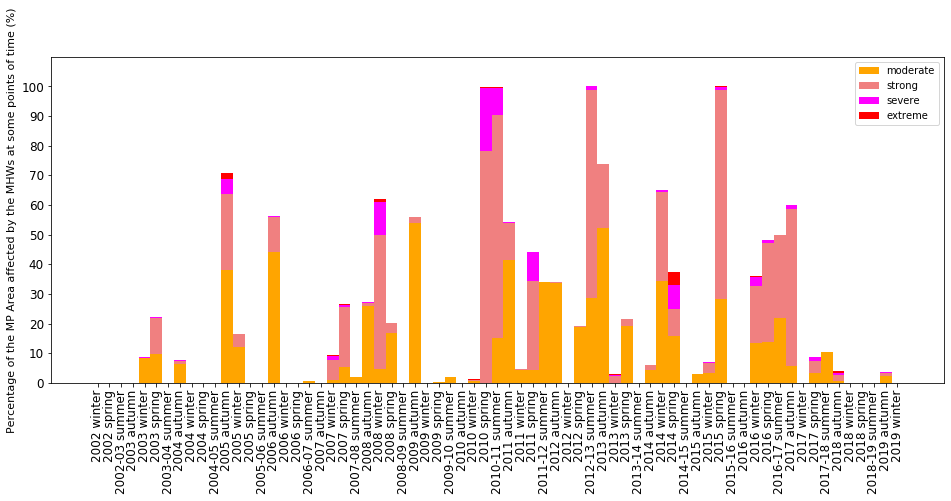

In [52]:

fig = plt.figure(figsize=(16,6))
# set up data
seasons = seasonClassDF4.index.values
moCount = seasonClassDF4['moPixels'].values
stCount = seasonClassDF4['stPixels'].values
seCount = seasonClassDF4['sePixels'].values
exCount = seasonClassDF4['exPixels'].values
totalPixels = sstIDF1.columns.size - 1

moP = moCount / totalPixels * 100
moP = np.nan_to_num(moP)
stP = stCount / totalPixels * 100
stP = np.nan_to_num(stP)
seP = seCount / totalPixels * 100
seP = np.nan_to_num(seP)
exP = exCount / totalPixels * 100
exP = np.nan_to_num(exP)
width = 1.0
plt.ylim([0,110])
p1 = plt.bar(seasons,moP,width,color='orange')
p2 = plt.bar(seasons,stP,width,bottom=moP,color='lightcoral')
p3 = plt.bar(seasons,seP,width,bottom=moP+stP,color='magenta')
p4 = plt.bar(seasons,exP,width,bottom=moP+stP+seP,color='red')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0]),('moderate','strong','severe','extreme'))
plt.ylabel("Percentage of the MP Area affected by the MHWs at some points of time (%)",fontsize=11)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


**plot a figure showing the numbers of MHW days with different categories, non-MHW days and nodata days**

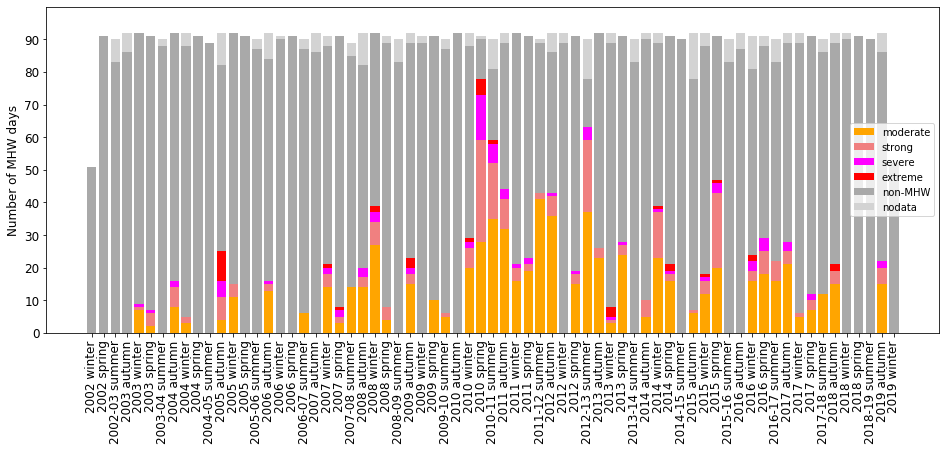

In [53]:
fig = plt.figure(figsize=(16,6))
# set up data
seasons = seasonClassDF4.index.values
moDays = seasonClassDF4['moDays'].values
stDays = seasonClassDF4['stDays'].values
seDays = seasonClassDF4['seDays'].values
exDays = seasonClassDF4['exDays'].values
nodataDays = seasonClassDF4['nodataDays'].values
totalDays = seasonClassDF4['noDays'].values
nonMHWDays = totalDays - nodataDays - exDays - seDays - stDays - moDays

width = 0.8
plt.ylim([0,100])
p1 = plt.bar(seasons,moDays,width,color='orange')
p2 = plt.bar(seasons,stDays,width,bottom=moDays,color='lightcoral')
p3 = plt.bar(seasons,seDays,width,bottom=moDays+stDays,color='magenta')
p4 = plt.bar(seasons,exDays,width,bottom=moDays+stDays+seDays,color='red')
p5 = plt.bar(seasons,nonMHWDays,width,bottom=moDays+stDays+seDays+exDays,color='darkgray')
p6 = plt.bar(seasons,nodataDays,width,bottom=moDays+stDays+seDays+exDays+nonMHWDays,color='lightgray')
plt.yticks(np.arange(0,100,10))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('moderate','strong','severe','extreme','non-MHW','nodata'))
plt.ylabel("Number of MHW days",fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


**plot a figure showing the daily variation of the percentages of marine park area affected by MHW, non-MHW and nodata**

select the season with the highest number of MHW days as an example

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


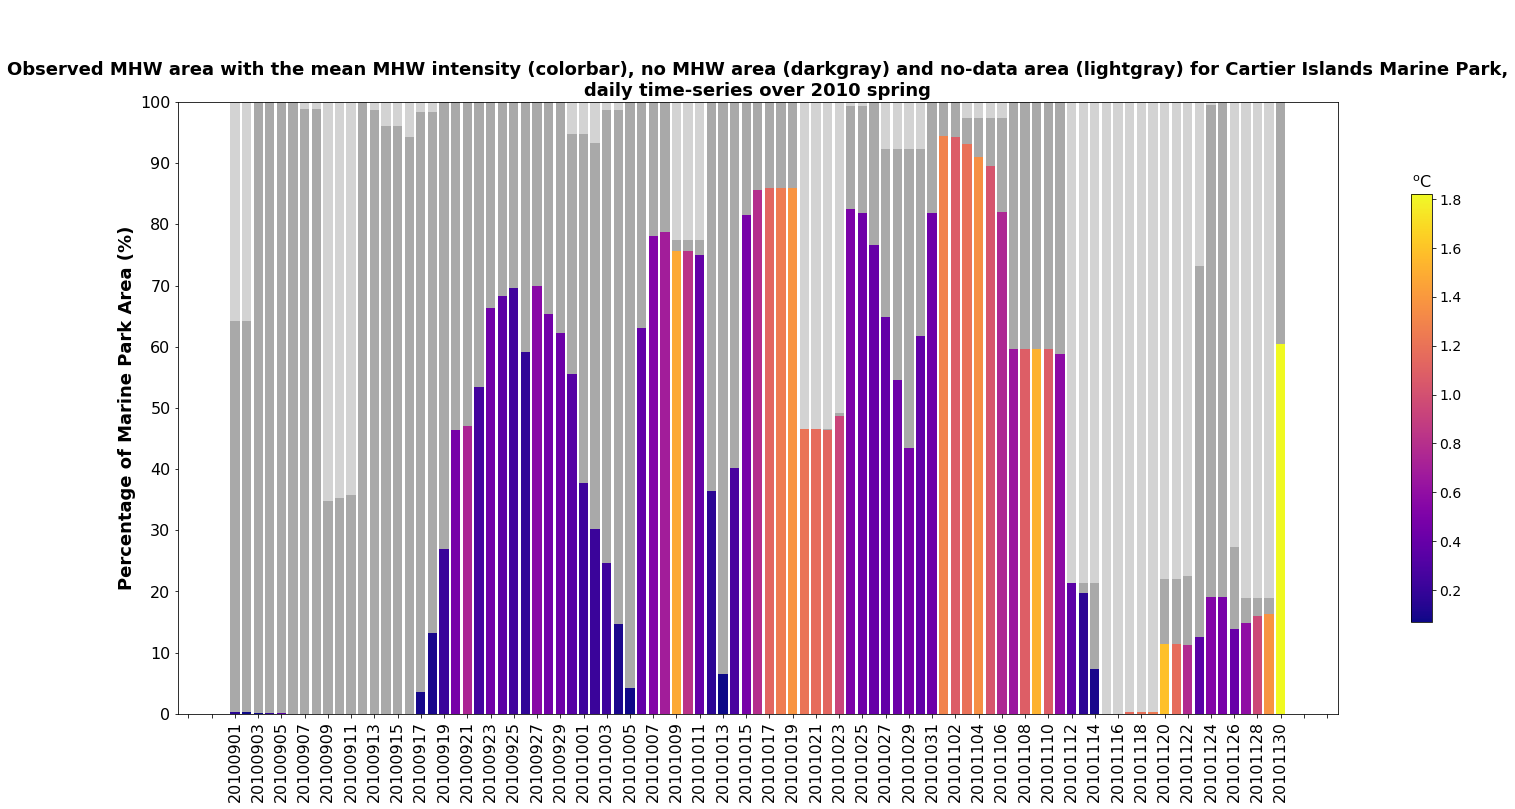

In [55]:

fig = plt.figure(figsize=(26,13))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
# select the season with the highest number of mhw days
tempDF = seasonDF4[seasonDF4['mhwDays'] == seasonDF4['mhwDays'].max()]
seasonIndex = tempDF.index[0]
year = seasonIndex.split(' ')[0]
season = seasonIndex.split(' ')[1]
if season == 'winter':
    date1 = year + '0601'
    date2 = year + '0831'
if season == 'spring':
    date1 = year + '0901'
    date2 = year + '1130'
if season == 'summer':
    date1 = year + '1201'
    date2 = str(int(year)+1) + '0228'
if season == 'autumn':
    date1 = year + '0301'
    date2 = year + '0531'
   
seasonYear = statsDF4.loc[date1:date2]
x = seasonYear.index.values
totalPixels = sstIDF1.columns.size - 1
mhwPixels = seasonYear['count'].values
noMHWPixels = seasonYear['observed'].values - seasonYear['count'].values
nodataPixels = totalPixels - seasonYear['observed'].values

mhwP = mhwPixels / totalPixels * 100
noMHWP = noMHWPixels / totalPixels * 100
nodataP = nodataPixels / totalPixels * 100
z1 = seasonYear['mean'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], mhwP[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], noMHWP[i], bottom=mhwP[i],facecolor="darkgray", alpha=1)
    ax1.bar(x[i], nodataP[i], bottom=mhwP[i]+noMHWP[i],facecolor="lightgray", alpha=1)
    i += 1

ax1.set_ylabel('Percentage of Marine Park Area (%)',fontsize=18,fontweight='bold')
ax1.set_title('Observed MHW area with the mean MHW intensity (colorbar), no MHW area (darkgray) and no-data area (lightgray) for ' + AMP_name + ' Marine Park,' + '\n' + 'daily time-series over ' + seasonIndex, fontsize=18, fontweight='bold')
ax1.set_yticks(np.arange(0,110,10))
ax1.set_yticklabels(np.arange(0,110,10),fontsize=16)
loc = ticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(16)

# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.ax.set_title('$\mathregular{^oC}$', fontsize=16, rotation=0)
cbar.ax.tick_params(labelsize=14)
plt.show()

**plot a figure showing the daily variation of the percentages of marine park area affected by different MHW categories, non-MHW and nodata**

select the season with the highest number of MHW days as an example

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


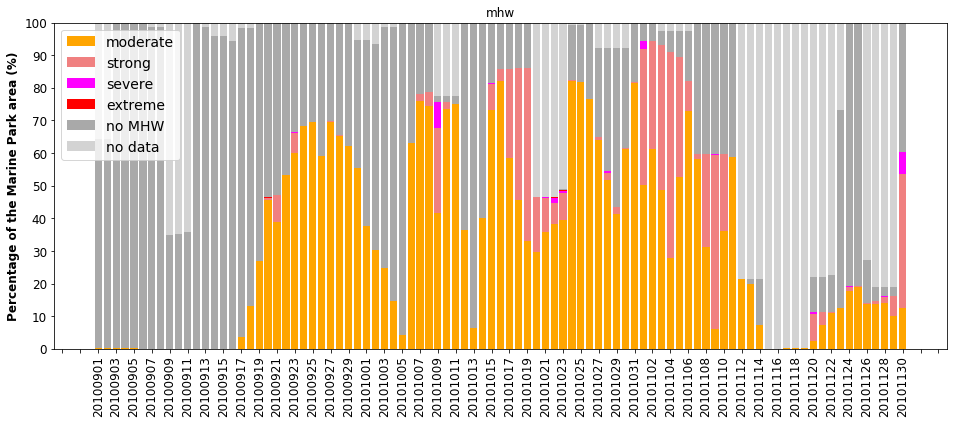

In [56]:

fig = plt.figure(figsize=(16,6))
# set up data
# select the season with the highest number of mhw days
tempDF = seasonClassDF4[seasonClassDF4['mhwDays'] == seasonClassDF4['mhwDays'].max()]
seasonIndex = tempDF.index[0]
year = seasonIndex.split(' ')[0]
season = seasonIndex.split(' ')[1]
if season == 'winter':
    date1 = year + '0601'
    date2 = year + '0831'
if season == 'spring':
    date1 = year + '0901'
    date2 = year + '1130'
if season == 'summer':
    date1 = year + '1201'
    date2 = str(int(year)+1) + '0228'
if season == 'autumn':
    date1 = year + '0301'
    date2 = year + '0531'
seasonYear = statsClassDF4.loc[date1:date2]
days = seasonYear.index.values

totalPixels = sstIDF1.columns.size - 1
noMHWPixels = seasonYear['observed'].values - seasonYear['count'].values
nodataPixels = totalPixels - seasonYear['observed'].values

moCount = seasonYear['moCount'].values
stCount = seasonYear['stCount'].values
seCount = seasonYear['seCount'].values
exCount = seasonYear['exCount'].values

moP = moCount / totalPixels * 100
stP = stCount / totalPixels * 100
seP = seCount / totalPixels * 100
exP = exCount / totalPixels * 100

noMHWP = noMHWPixels / totalPixels * 100
nodataP = nodataPixels / totalPixels * 100

width = 0.8
plt.ylim([0,100])
p1 = plt.bar(days,moP,width,color='orange')
p2 = plt.bar(days,stP,width,bottom=moP,color='lightcoral')
p3 = plt.bar(days,seP,width,bottom=moP+stP,color='magenta')
p4 = plt.bar(days,exP,width,bottom=moP+stP+seP,color='red')
p5 = plt.bar(days,noMHWP,width,bottom=moP+stP+seP+exP,color='darkgray')
p6 = plt.bar(days,nodataP,width,bottom=moP+stP+seP+exP+noMHWP,color='lightgray')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('moderate','strong','severe','extreme','no MHW','no data'),fontsize=14)
plt.ylabel("Percentage of the Marine Park area (%)",fontsize=12,fontweight='bold')
plt.title("mhw")
loc = ticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax = plt.axes()
ax.xaxis.set_major_locator(loc)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()

### Convert MHW results to xarray datasets

**convert the summarised per-pixel MHW results to xarray dataset**

In [57]:
mhwDF4.set_index('pointID',inplace=True)

mhwDF5 = mhwDF4.copy()
xList = []
yList = []
for id in mhwDF5.index:
    x = mhwDF5.loc[id]['lon'].item()
    y = mhwDF5.loc[id]['lat'].item()
    xList.append(round(x,3))
    yList.append(round(y,3))

mhwDF5['lon'] = xList
mhwDF5['lat'] = yList

mhwDF5.set_index(['lat','lon'],inplace=True)
mhwData = xr.Dataset.from_dataframe(mhwDF5)
mhwData.attrs['crs']=output_crs



**check the data**

In [58]:
mhwData

<xarray.Dataset>
Dimensions:               (lat: 190, lon: 75)
Coordinates:
  * lat                   (lat) float64 -23.57 -23.55 -23.55 ... -21.68 -21.68
  * lon                   (lon) float64 113.5 113.5 113.5 ... 114.2 114.2 114.2
Data variables:
    noEvents              (lat, lon) float64 nan nan nan nan ... 19.0 20.0 17.0
    noDays                (lat, lon) float64 nan nan nan ... 141.0 138.0 121.0
    totalIntensity        (lat, lon) float64 nan nan nan ... 102.6 99.05 98.7
    overallIntensity      (lat, lon) float64 nan nan nan ... 0.7177 0.8157
    highestIntensity      (lat, lon) float64 nan nan nan ... 3.369 3.49 3.533
    date_start_HI         (lat, lon) float64 nan nan ... -1.547e+03 -1.547e+03
    duration_HI           (lat, lon) float64 nan nan nan nan ... 6.0 6.0 5.0 5.0
    largestDuration       (lat, lon) float64 nan nan nan nan ... 20.0 16.0 15.0
    date_start_LD         (lat, lon) float64 nan nan nan ... -704.0 -703.0
    intensityLD           (lat, lon) float64 nan nan nan ... 0.7356 0.6875
    largestMeanIntensity  (lat, lon) float64 nan nan nan ... 1.579 1.72 1.583
    date_start_LMI        (lat, lon) float64 nan nan nan ... -684.0 -684.0
    duration_LMI          (lat, lon) float64 nan nan nan nan ... 5.0 5.0 5.0 5.0
    largestCumIntensity   (lat, lon) float64 nan nan nan ... 13.15 11.77 10.59
    date_start_LCI        (lat, lon) float64 nan nan nan ... -704.0 -1.538e+03
    duration_LCI          (lat, lon) float64 nan nan nan nan ... 20.0 16.0 11.0
    moderate              (lat, lon) float64 nan nan nan ... 128.0 125.0 110.0
    strong                (lat, lon) float64 nan nan nan nan ... 12.0 12.0 9.0
    severe                (lat, lon) float64 nan nan nan nan ... 1.0 1.0 1.0 2.0
    extreme               (lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:4326

**add x and y coordinates (must be integer) to the dataframes**

**delete rows (dates) that have not impacted by the MHW. This signficantly reduces the size of 
the dataframe and the running time**

For example, in this case from original 6210 days to 275 days

In [59]:
time1 = datetime.now()
statsDF6 = statsDF4.copy()
statsDF6 = statsDF6.fillna(-1) # replace nodata with '-1'
for i in statsDF6.index:
    count = statsDF6.loc[i,'count']
    if count == 0:
        statsDF6.drop(index=i,inplace=True)
statsDF6 = statsDF6.drop(columns=['min','max','mean','std','count','observed'])
xList = []
yList = []
for i in statsDF6.columns:
    x = mhwDF4['lon'][int(i)].item()
    y = mhwDF4['lat'][int(i)].item()
    xList.append(round(x,3))
    yList.append(round(y,3))
statsDF6 = statsDF6.T
statsDF6['lon']=xList
statsDF6['lat']=yList
statsDF6.index.names = ['pointID']
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

It took  0:02:01.604704  to finish


In [60]:
time1 = datetime.now()
statsClassDF6 = statsClassDF4.copy()
statsClassDF6 = statsClassDF6.fillna(-1)
for i in statsClassDF6.index:
    count = statsClassDF6.loc[i,'count']
    if count == 0:
        statsClassDF6.drop(index=i,inplace=True)
statsClassDF6 = statsClassDF6.drop(columns=['moCount','stCount','seCount','exCount','count','observed'])
xList = []
yList = []
for i in statsClassDF6.columns:
    x = mhwDF4['lon'][int(i)].item()
    y = mhwDF4['lat'][int(i)].item()
    xList.append(round(x,3))
    yList.append(round(y,3))
statsClassDF6 = statsClassDF6.T
statsClassDF6['lon']=xList
statsClassDF6['lat']=yList
statsClassDF6.index.names = ['pointID']
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

It took  0:01:57.474958  to finish


**convert dataframes to xarray dataset**

In [61]:
statsDF6.set_index(['lat','lon'],inplace=True)
statsData = xr.Dataset.from_dataframe(statsDF6)
statsData.attrs['crs']=output_crs


In [62]:
statsClassDF6.set_index(['lat','lon'],inplace=True)
statsClassData = xr.Dataset.from_dataframe(statsClassDF6)
statsClassData.attrs['crs']=output_crs


**plot the summary statistics as maps**

use total MHW intensity and number of severe MHW days as examples

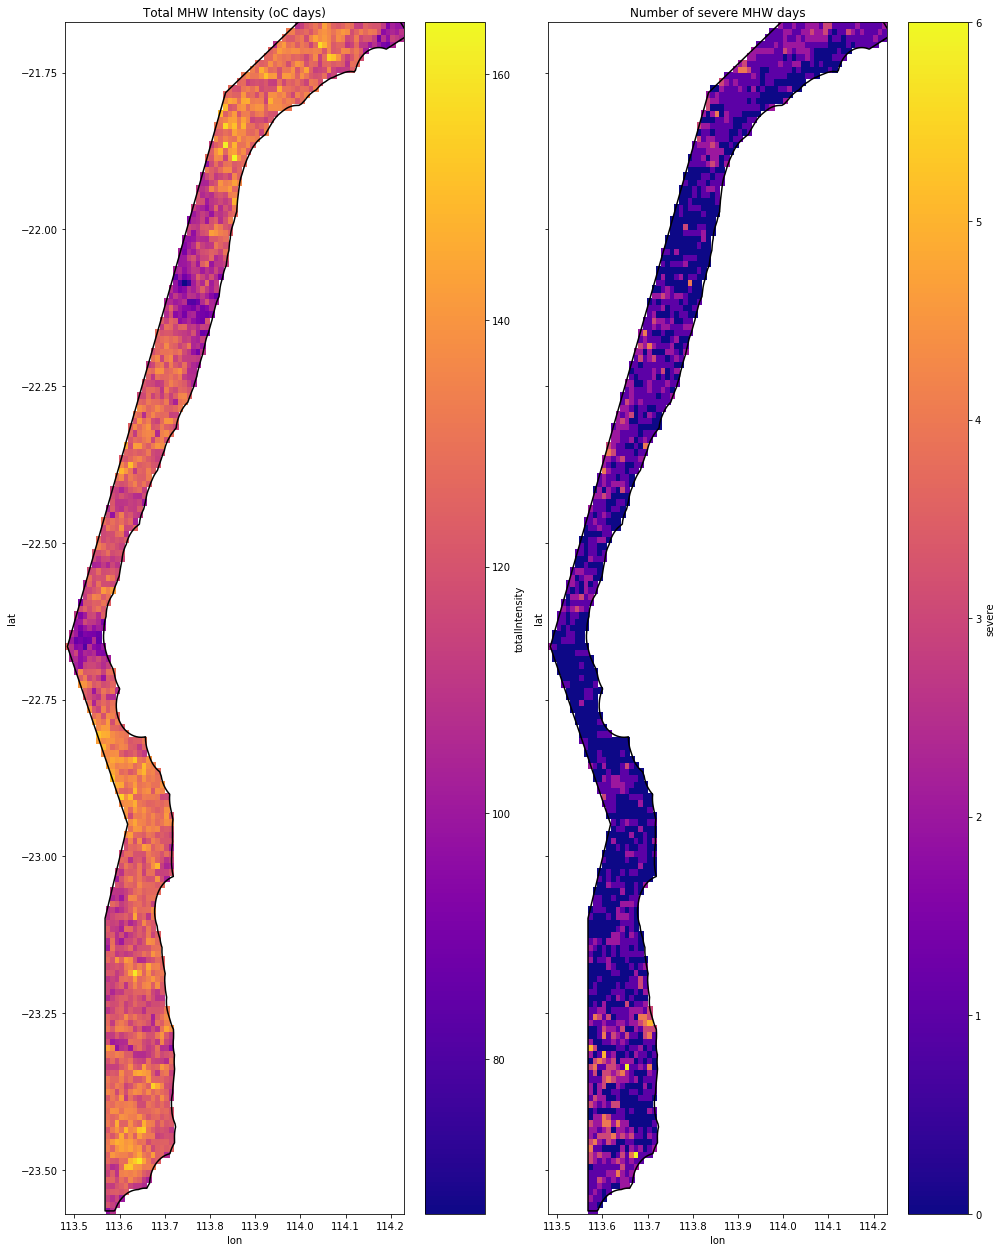

In [63]:
AMP = shpf.Reader(AMP_shp)
width = 14
height = round(width * h_w_ratio)
f, (ax1,ax2) = plt.subplots(1,2,sharey='all',figsize=(width,height/2))

#totalIntensity
if os.path.exists(reefs_shp):    
    shape_plot = gpd.read_file(reefs_shp)
    shape_plot.plot(color='gray',ax=ax1)

mhwData.totalIntensity.plot(cmap='plasma',ax=ax1)
ax1.set_title('Total MHW Intensity (oC days)')
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x, y, 'k')
#number of severe MHW days
if os.path.exists(reefs_shp):    
    shape_plot = gpd.read_file(reefs_shp)
    shape_plot.plot(color='gray',ax=ax2)
mhwData.severe.plot(cmap='plasma',ax=ax2)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x, y, 'k')

ax2.set_title('Number of severe MHW days')
f.tight_layout() 
plt.show()

**plot daily MHW maps**

use the MHW intensity and the MHW categories of the day with the maximum number of MHW pixels as examples

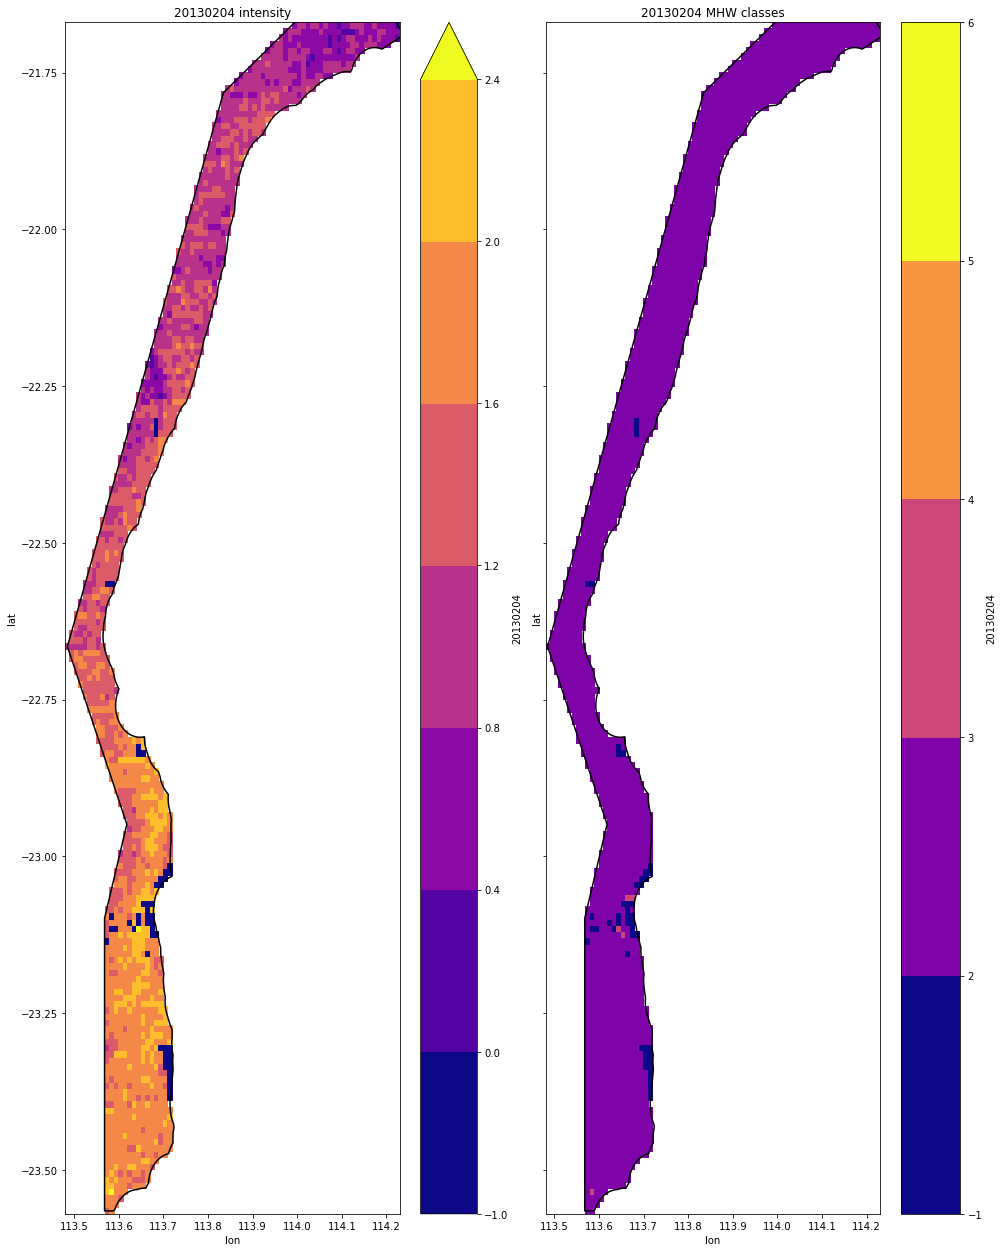

In [64]:

AMP = shpf.Reader(AMP_shp)
width = 14
height = round(width * h_w_ratio)
f, (ax1,ax2) = plt.subplots(1,2,sharey='all',figsize=(width,height/2))
# select the data with maximum number of MHW pixels
tempDF = statsDF4[statsDF4['count'] == statsDF4['count'].max()]
var = tempDF.index[0]
# try to use discrete colormap to display the maps
# note that nodata pixels (value = -1) are also shown
#MHW intensity
maxV = statsData[var].max()
levels = np.arange(0,maxV,0.4) # class interval value is set at 0.4
levels = np.insert(levels,0,-1) # value -1 (nodata) is used as anthor discrete level
statsData[var].plot(levels=levels,cbar_kwargs={"ticks": levels},cmap='plasma',ax=ax1)
if os.path.exists(reefs_shp):        
    shape_plot = gpd.read_file(reefs_shp)
    shape_plot.plot(color='gray',ax=ax1)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x, y, 'k')

ax1.set_title(var + ' intensity')

#MHW categories
if os.path.exists(reefs_shp):        
    shape_plot = gpd.read_file(reefs_shp)
    shape_plot.plot(color='gray',ax=ax2)
# 2-3 -> moderate MHW category; 3-4 -> strong MHW category; 4-5 -> severe MHW category; 5-6 -> extreme MHW category
# -1 -> nodata
statsClassData[var].plot(levels=[-1,2,3,4,5,6],cmap='plasma',ax=ax2)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x, y, 'k')

ax2.set_title(var + ' MHW classes')
f.tight_layout()
plt.show()


In [65]:
then = time.time()

elapsed = then - now
print("It took", elapsed, "second")

It took 17655.996069669724 second


## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** April 2020
   
**Compatible datacube version:** 

In [66]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)